# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import os
import pprint 
import matplotlib.pyplot as plt
%matplotlib inline

from d4pg_agent import D4PG_Agent
from params import Params
from logger import Logger

In [3]:
torch.autograd.set_detect_anomaly(True)

In [4]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe')
# env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 9.99999225e-01  1.27272622e-03  0.00000000e+00  2.25000000e+00
  1.00000036e+00 -3.22882910e-12 -1.19209290e-07  3.22882975e-12
  1.00000000e+00 -3.22882910e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  5.00000000e-01
  5.00000000e-01  0.00000000e+00  5.00000000e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339918e+00 -1.42857209e-01
 -1.33341408e+00  5.00000000e-01  0.00000000e+00  0.00000000e+00
  5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [16]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.722786005702801


## Get a rough estimate of bounds of reward function, to init V_min and V_max

In [6]:
# NOTE: INTERRUPT KERNAL TO STOP ANALYSIS

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
max_reward = 0.0
min_reward = 0.0
max_action = 0.0
min_action = 0.0
eps_max = 1000
iters = 0

while iters < eps_max:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    
    # DEBUG: PLOT GRAPH OF REWARDS
    max_reward = max(rewards) if (max(rewards) > max_reward) else max_reward
    min_reward = min(rewards) if (min(rewards) < min_reward) else min_reward
    max_action = np.amax(actions) if (np.amax(actions) > max_action) else max_action
    min_action = np.amin(actions) if (np.amin(actions) < min_action) else min_action
    iters += 1
    print("\rEpisode: {} \tMAX REWARD: {:.2f} \tMIN REWARD: {:.2f} \tMAX ACTION: {:.2f} \tMIN ACTION: {:.2f}".format(iters, max_reward, min_reward, max_action, min_action), end="")

    
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step    
    #if np.any(dones):                                  # exit loop if episode finished
    #    break


Episode: 1000 	MAX REWARD: 1.39 	MIN REWARD: -1.48 	MAX ACTION: 4.67 	MIN ACTION: -5.00

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

In [26]:
def d4pg(params=Params(), logger=Logger()):
    
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    logger.initialize(agent, state_size, action_size)
    
    try:
    
        start_eps = params.eps_to_resume_from if not params.restart_training else 1        
        for i_episode in range(start_eps, params.n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
            states = env_info.vector_observations              # get the current state
            agent.reset()
            score = np.zeros(len(env_info.agents))

            for t in range(params.max_t):                             

                # REPORT NAN STATES
                if np.isnan(states).any():
                    print('\nNaN found in states. Skipping this episode.')
                    states = np.where(np.isnan(states), 0, states)
                    states = next_states
                    break
                
                # REPORT INF STATES
                if np.isinf(states).any():
                    print('\nINF found in states. Skipping this episode.')
                    states = np.where(np.isinf(states), 0, states)
                    states = next_states
                    break
                    
                # Perform actions from each agent's policy network (clipped actions [0, -1])
                actions = [ agent.act(state) for state in states ]  
                actions = np.stack(actions)            
                env_info = env.step(actions)[brain_name]      
                next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done

                # REPORT NAN ACTIONS
                if np.isnan(actions).any():
                    print('\nNaN found in actions. Skipping this episode.')
                    actions = np.where(np.isnan(actions), 0, actions)
                    states = next_states
                    break

                # REPORT NAN ACTIONS
                if np.isinf(actions).any():
                    print('\Inf found in actions. Skipping this episode.')
                    actions = np.where(np.isinf(actions), 0, actions)
                    states = next_states
                    break
                    
                # If rewards is super low / NaN for some reason, skip logging! (Prevent exploding gradients bug)
                low_rewards = np.array(rewards)<-30
                if any(low_rewards):                
                    mean_low_rewards = np.array(rewards)[low_rewards].mean()
                    print("Errorneously low Reward = {:.2f} Found! Doing nothing...".format(mean_low_rewards))
                    print(rewards)
                    # rewards = np.where(low_rewards, 0, rewards)
                    print("SKIPPING TRAINING OF THIS TIMESTEP")
                    states = next_states
                    continue
                    
                if np.isnan(rewards).any():
                    print("NaN Reward Found! Skipping this episode.")
                    rewards = np.where(np.isnan(rewards), -5.0, rewards)
                    states = next_states
                    break
                    #print("CORRECTED REWARDS: ", rewards)

                if np.isinf(rewards).any():
                    print("Inf Reward Found! Skipping this episode.")
                    rewards = np.where(np.isinf(rewards), -5.0, rewards)
                    states = next_states
                    break
                    #print("CORRECTED REWARDS: ", rewards)
                    
                # Allow crawler to keep resetting if fall, but reset score to 0 if so
                agent.step(states, actions, rewards, next_states, dones, clear_nstep_buffer=(t==0))
                states = next_states
                score += np.array(rewards)
                score = np.where(dones, 0, score)

                # Break if any of the agent is done
                if all(dones):   # any()
                    break 

            # Print crucial results for progress tracking
            if agent.memory_buffer_prefilled():

                logger.log_stats(i_episode, float(score.mean()), agent.actor_loss, agent.critic_loss)
                print('\rEpisode {}\ Score: {:.2f}'.format(i_episode, logger.scores_deque[-1]), end="")

                if i_episode % params.save_every == 0:
                    logger.save_weights(i_episode)

                if i_episode % params.print_every == 0:
                    print('\rEpisode {}: \tActor Loss: {:.2f} \tCritic Loss: {:.2f} \n\t\tAverage Score: {:.2f}\n'
                          .format(i_episode, np.mean(logger.actor_loss_deque), np.mean(logger.critic_loss_deque), np.mean(logger.scores_deque)))
                    print('SCORES (this eps): ', score, '\n')
                    logger.plot_categorical_probs()
                    
                    if np.mean(logger.scores_deque) >= params.target_score:
                        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                              .format(i_episode, np.mean(logger.scores_deque)))
                        if params.terminate_on_target_score:
                            break
                            
        # Plot graphs & save final weights
        logger.save_weights(i_episode)
        if params.plot_stats:
            logger.plot_stats()
            logger.plot_categorical_probs()
        logger.log_overall_perf_tb()

    # Catch any exceptions (Esp with keyboard interrupts)
    except BaseException as error:
        print('\n\n==== An exception occurred: {}'.format(error))
        logger.print_weights()
        logger.save_weights(i_episode)
        if params.plot_stats:
            logger.plot_stats()
            logger.plot_categorical_probs()
        logger.log_overall_perf_tb()
    
    return logger.scores_list


=============== NETWORKS ===============
actor_local Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=20, bias=True)
)
actor_target Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=20, bias=True)
)
criti

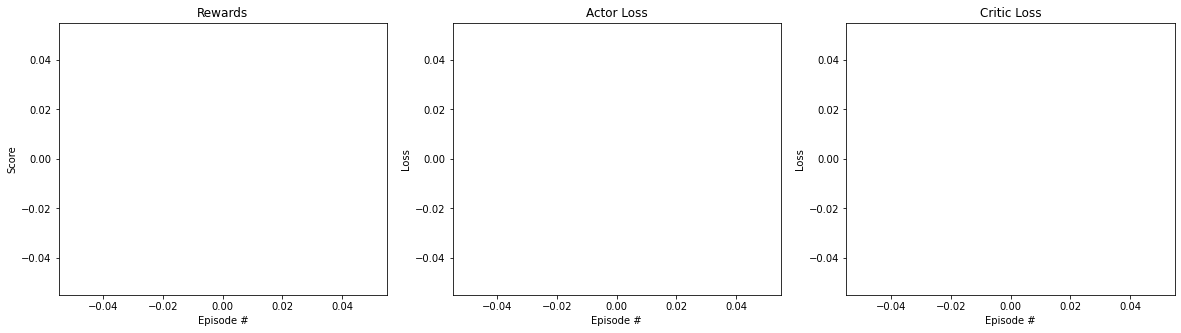

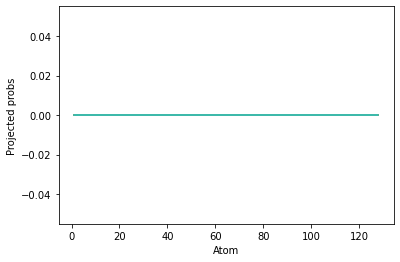

C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

In [23]:
##################
# QUICK TEST
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=3
params.max_t = 50
params.print_every = 100
params.save_every = 100
params.log_weights_every = 1
params.prefill_memory_qty=0
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.vmin = -3
params.vmax = 3


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

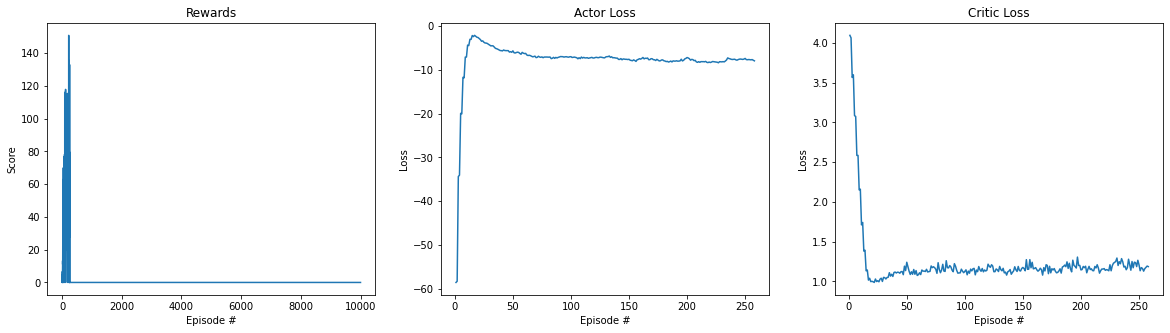

In [105]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    plt.show()
    
plot_graph(logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -2
VMAX:  2
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.14 	Critic Loss: 3.83 
		Average Score: 3.31

SCORES (this eps):  [0.         0.18586762 0.18781589 4.91786596 0.32156897 0.27364761
 0.66349444 4.46155315 2.57993309 3.60006285 3.43509428 3.45403221] 



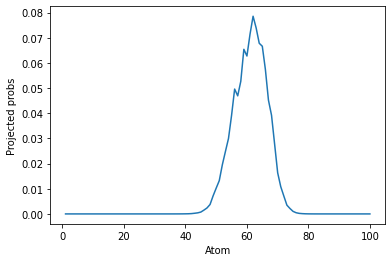

Episode 20: 	Actor Loss: -0.47 	Critic Loss: 3.63 
		Average Score: 3.36

SCORES (this eps):  [ 2.57516862  3.17451189  0.46693217  0.07922503  5.564624   12.13195447
  2.81854155  2.39018161  2.20975653  0.12296586  2.45316236  0.90063324] 



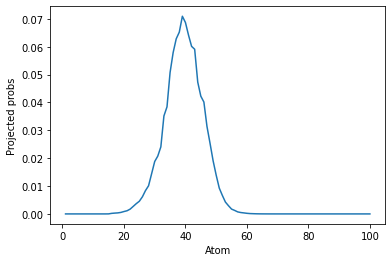

Episode 30: 	Actor Loss: -0.90 	Critic Loss: 3.32 
		Average Score: 9.46

SCORES (this eps):  [17.71689714  0.34908045  3.51957793 11.31296962  6.15221967  2.29455877
  2.05489846  8.53540981  4.41563733  0.07169021  9.92597251  2.09831346] 



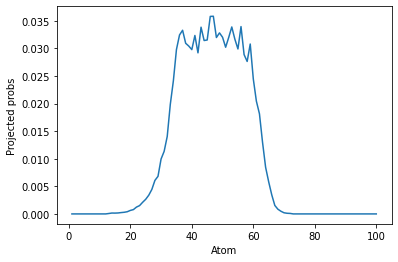

Episode 40: 	Actor Loss: -1.14 	Critic Loss: 2.96 
		Average Score: 9.03

SCORES (this eps):  [10.96229334 10.12718591 12.29180975  9.91860334  2.00473328  6.69236193
  9.7542256  17.11337151  2.91353213  7.0290861  14.18687061 12.29773657] 



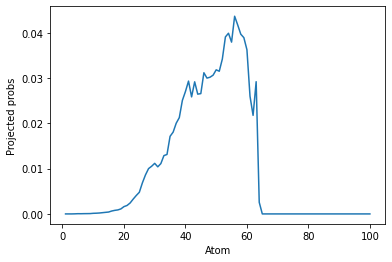

Episode 50: 	Actor Loss: -1.24 	Critic Loss: 2.65 
		Average Score: 10.53

SCORES (this eps):  [ 11.47943796 -12.82529258  13.18292046  14.0181106   12.32446132
   5.75198882  14.20385874   6.4100047    6.34132881   2.97272309
  13.99443524   2.37405397] 



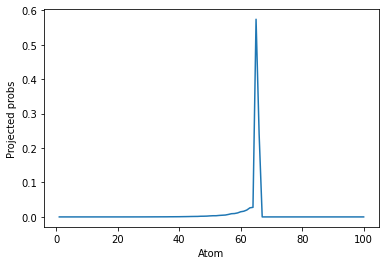

Episode 60: 	Actor Loss: -1.30 	Critic Loss: 2.49 
		Average Score: 13.16

SCORES (this eps):  [ 9.54498356 27.90109435  3.11765912  5.39922535  9.46090406  4.37732155
 14.60787352  6.17460481  6.6748245  24.97311987 45.17000544  3.7647182 ] 



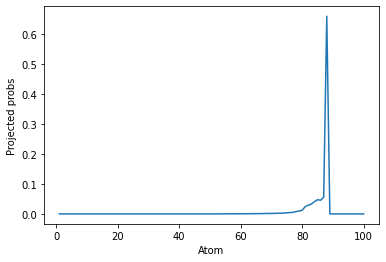

Episode 70: 	Actor Loss: -1.36 	Critic Loss: 2.31 
		Average Score: 16.19

SCORES (this eps):  [51.02578137 14.56518344 62.96690766 50.001803   22.79712374 27.06189511
 13.48268392  6.85169314 22.12771247  1.01461987 18.70085967 44.2330993 ] 



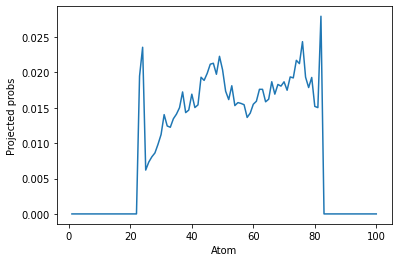

Episode 80: 	Actor Loss: -1.44 	Critic Loss: 2.14 
		Average Score: 19.17

SCORES (this eps):  [40.49905536 38.64163614  5.22901002 42.13669271  6.92708144  4.25443585
  6.53302442 45.12929942  3.90122059  2.52358248  4.71217014  5.01990166] 



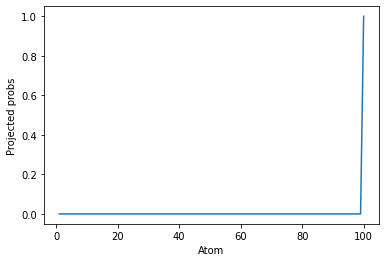

Episode 90: 	Actor Loss: -1.52 	Critic Loss: 1.91 
		Average Score: 24.32

SCORES (this eps):  [ 2.92030001  8.54788984 11.27854122 10.09045275 11.89337797 11.78497504
 46.34588758  5.19191939  0.         27.23103247  9.27157123  4.65589623] 



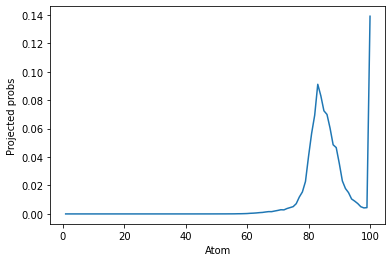

Episode 100: 	Actor Loss: -1.63 	Critic Loss: 1.59 
		Average Score: 23.36

SCORES (this eps):  [111.50693925  21.07318996   9.81267913  21.9004324   26.91342956
  28.97439829   5.2276932    8.2303556   65.06271709  43.47204635
  21.62948105  10.80702001] 



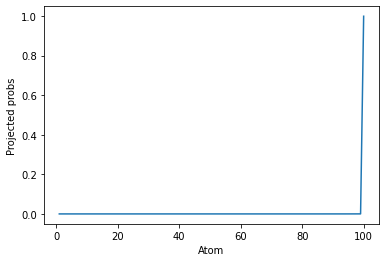

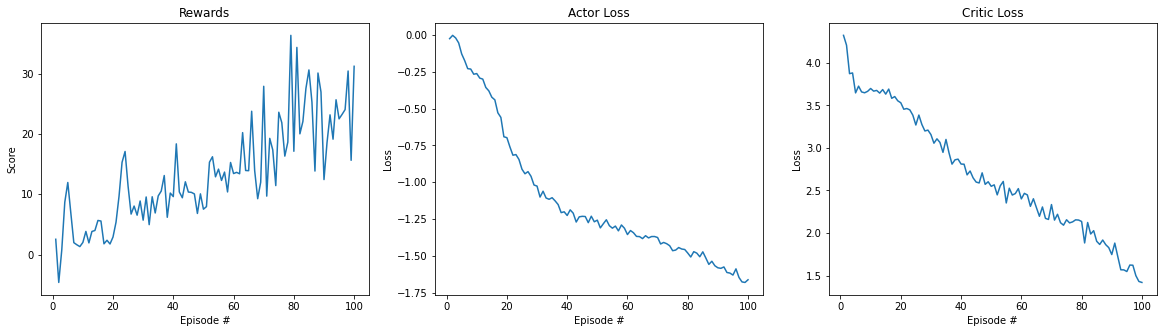

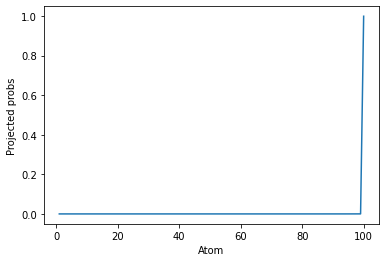

[2.531138189656,
 -4.627917923401886,
 0.764199839051192,
 8.677270784358067,
 11.948230314437145,
 6.906347084188989,
 1.9700123351067305,
 1.6211440834449604,
 1.3165993820099782,
 2.006744671962224,
 3.834877892707785,
 1.9323424469427362,
 3.8247035837266594,
 3.990450586619166,
 5.654060917169166,
 5.555374063939477,
 1.7796045910023774,
 2.368124367746835,
 1.7500692643225193,
 2.907304777375733,
 5.370251698923918,
 9.677908066854192,
 15.291278733871877,
 17.09162691968959,
 11.328756280903084,
 6.710092737863306,
 8.040875483852384,
 6.527927532636871,
 8.879774033674039,
 5.70393544769225,
 9.546915864727149,
 4.955659109555806,
 9.582948654618425,
 6.894040136384622,
 9.725159903561385,
 10.529548016143963,
 13.102559644728899,
 6.177061278528224,
 10.195103505820347,
 9.607650838249052,
 18.354878537279244,
 10.381240988140538,
 9.4168377975584,
 12.063554795924574,
 10.36446404400825,
 10.312605268671177,
 10.049668433105884,
 6.814845278975554,
 10.063461283842722,
 7.519

In [24]:
##################
# Vmax = -Vmin = 2
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_2'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_2'
params.num_atoms = 100
params.vmin = -2
params.vmax = 2


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -5
VMAX:  5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.09 	Critic Loss: 3.46 
		Average Score: -1.84

SCORES (this eps):  [ 0.94236293  0.44802137  0.97641426  0.91901076  1.06776543 17.64876091
  0.76071538  0.49145962  1.05551678  0.46184647  0.25544391  0.7669073 ] 



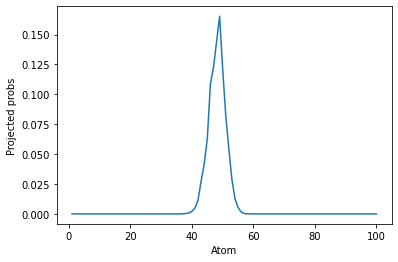

Episode 20: 	Actor Loss: -0.75 	Critic Loss: 2.98 
		Average Score: 3.45

SCORES (this eps):  [ 5.38858248  0.87526961  5.82314635 16.34254459  1.25826387  0.84870289
  2.93873842  1.06380316  0.97008278  2.93891869  0.05891044  1.11360322] 



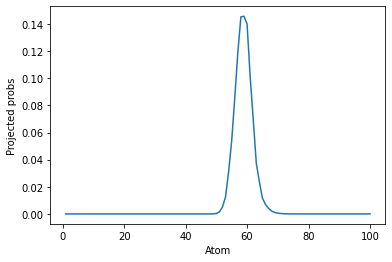

Episode 30: 	Actor Loss: -1.53 	Critic Loss: 3.07 
		Average Score: 5.62

SCORES (this eps):  [2.57457972e+00 3.92896533e-02 2.67915116e+00 2.36453346e+01
 3.78618698e+00 1.68427341e-02 1.24166843e+01 2.33288534e-01
 6.28062114e-02 1.18897786e+01 5.44619630e+00 1.40637742e+01] 



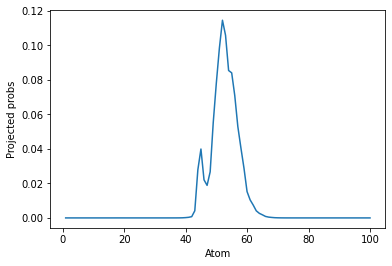

Episode 40: 	Actor Loss: -2.06 	Critic Loss: 3.05 
		Average Score: 11.26

SCORES (this eps):  [13.47893887 30.0048569   5.63940105 11.05898678 11.09638577 29.65855336
  2.22287624 24.56597782 24.76017143 14.21578178  5.44832241  8.15614547] 



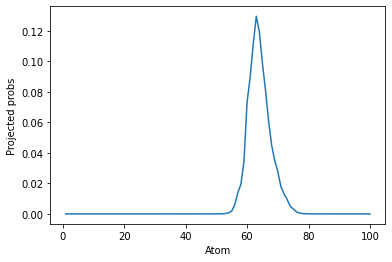

Episode 50: 	Actor Loss: -2.42 	Critic Loss: 2.94 
		Average Score: 12.96

SCORES (this eps):  [18.0597099  10.35430314  9.74294411 14.30692717  4.82840408  5.51277662
 12.51191662 10.48046449 39.10779939  0.08797283 20.25282829 16.33218889] 



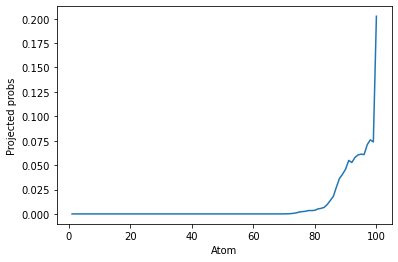

Episode 60: 	Actor Loss: -2.66 	Critic Loss: 2.87 
		Average Score: 17.72

SCORES (this eps):  [1.46152166e+01 1.08484358e+01 2.57343635e-01 8.20244822e+01
 7.53605950e+00 1.11392761e+01 9.23998430e-02 9.51263721e+00
 3.12598147e+01 1.54372551e+01 2.38382258e-02 1.42627516e+01] 



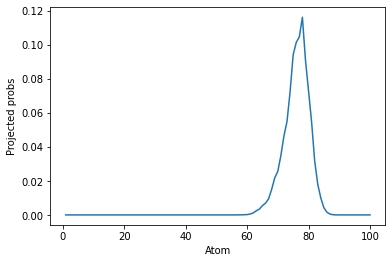

Episode 70: 	Actor Loss: -2.82 	Critic Loss: 2.78 
		Average Score: 18.50

SCORES (this eps):  [ 20.3811757    0.21214299   2.98562485   5.17048045   1.1866641
  11.23750015   4.89276861   4.19640952 110.03147605   2.99241219
   7.83717296   8.39296657] 



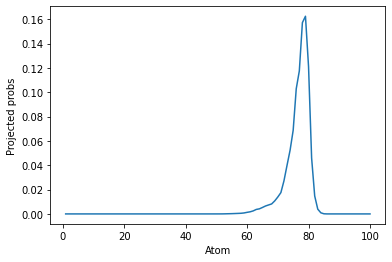

Episode 80: 	Actor Loss: -2.99 	Critic Loss: 2.73 
		Average Score: 22.78

SCORES (this eps):  [ 83.72942113  22.7533843  120.9917224    8.66776267   1.93648494
  88.04614136   0.           1.12213396   1.2297461   18.66808037
   7.83074382  66.8974436 ] 



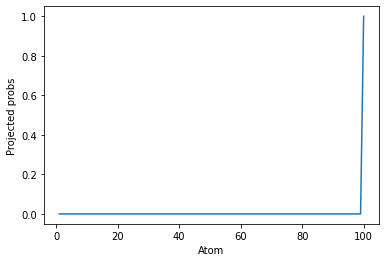

Episode 90: 	Actor Loss: -3.15 	Critic Loss: 2.65 
		Average Score: 26.94

SCORES (this eps):  [ 1.35592326e+01  1.93677278e+01  3.07423621e+01  1.82553283e+01
  6.07052870e+00  2.62948717e+01  1.60190228e+01 -1.33703374e+01
  1.06172257e+01  3.21999380e+01 -1.91885233e-02  3.16547271e+01] 



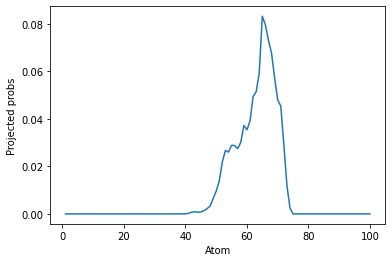

Episode 100: 	Actor Loss: -3.46 	Critic Loss: 2.52 
		Average Score: 31.30

SCORES (this eps):  [ 24.16126858   7.55202582  44.94044347  31.89756151 106.55539134
   3.91193252  16.54596015   0.25277775  23.41529608  10.94988385
  40.95198424  26.60465124] 



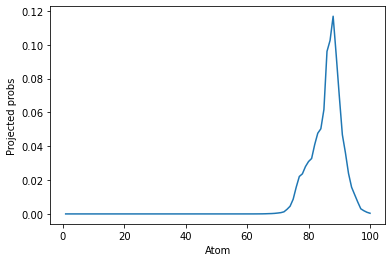

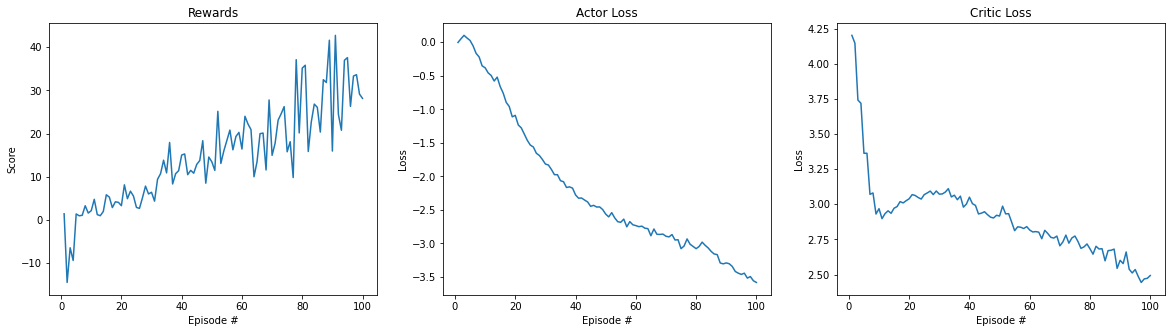

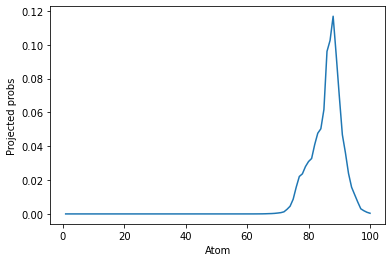

[1.4288723260069673,
 -14.475138469248728,
 -6.447534060105681,
 -9.387789559075221,
 1.3845240904095892,
 0.9607462104953205,
 1.0733349584043026,
 3.2860649546297886,
 1.5913779638552417,
 2.149518759921193,
 4.772654525392379,
 1.2278054618897538,
 0.9809587324659029,
 1.960111877337719,
 5.827904016400377,
 5.283544434389721,
 2.8608720738751194,
 4.192382634306948,
 4.077378602388005,
 3.3017138732442013,
 8.130975213445103,
 4.919357223513846,
 6.660393110010773,
 5.533511726884171,
 2.894200465253865,
 2.6779457178587713,
 5.142935609134535,
 7.834053911268711,
 6.016445546464335,
 6.404492746883382,
 4.352224099993085,
 9.423222701686123,
 10.717399239831138,
 13.825029101998856,
 10.890753724806322,
 17.938867794931866,
 8.330109757681688,
 10.704143172479235,
 11.409516010278216,
 15.025533156624684,
 15.27937022363767,
 10.481991667804929,
 11.480048421925554,
 10.820086754315222,
 12.860795805812813,
 13.758066087883586,
 18.347520638102043,
 8.509667816300256,
 14.56901009

In [25]:
##################
# Vmax = -Vmin = 5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_5'
params.num_atoms = 100
params.vmin = -5
params.vmax = 5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -10
VMAX:  10
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.23 	Critic Loss: 3.28 
		Average Score: 9.35

SCORES (this eps):  [ 1.905939    7.88530333  8.27647731 20.6359955  23.26489683 13.69319645
  1.45613457  0.28228954  0.92498702  5.89917324  7.62962972  0.        ] 



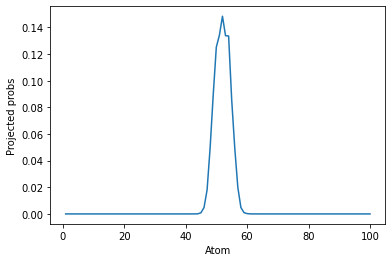

Episode 20: 	Actor Loss: -1.22 	Critic Loss: 2.56 
		Average Score: 4.57

SCORES (this eps):  [ 3.91945288 18.92383274  0.33052016  5.03363822  1.99430179  0.11848765
  0.05230379  5.76268058  2.1557624   0.28262769  3.15159368  0.40484414] 



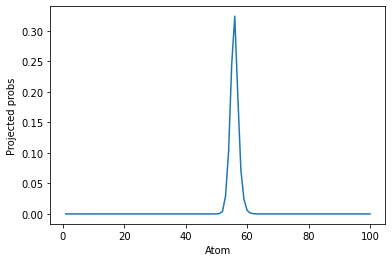

Episode 30: 	Actor Loss: -1.88 	Critic Loss: 2.70 
		Average Score: 11.69

SCORES (this eps):  [18.4906898   8.50851772  0.68243101 14.49184502  1.14191242  0.52495383
  2.09791808 51.79214847 29.44555232 15.58787178  8.4097856   3.67199275] 



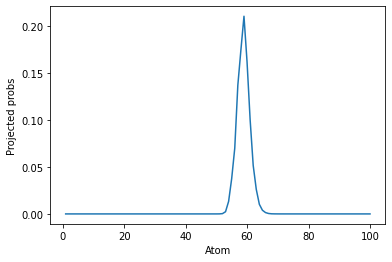

Episode 40: 	Actor Loss: -2.51 	Critic Loss: 2.77 
		Average Score: 13.87

SCORES (this eps):  [13.46684615 27.95952972  0.51596803  6.35423225  6.58802256  9.08788976
 18.09460035 21.1806765   5.46226962 31.26094396 50.7944175   1.09112813] 



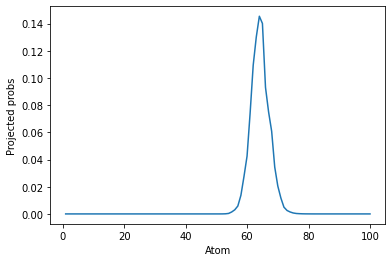

Episode 50: 	Actor Loss: -2.91 	Critic Loss: 2.78 
		Average Score: 8.76

SCORES (this eps):  [32.79304355  0.79620005  4.59849397 28.29309762  5.78993225  3.60773532
 12.59555029 18.61252003 17.04026808  7.44924525 46.93438328 42.14856081] 



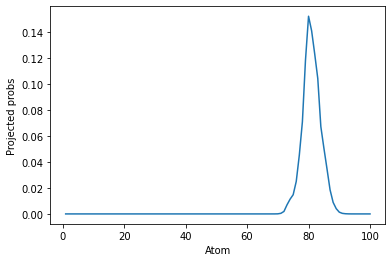

Episode 60: 	Actor Loss: -3.14 	Critic Loss: 2.85 
		Average Score: 15.60

SCORES (this eps):  [ 9.03059791 12.73257528  1.11150846 10.86587656  3.53239991 36.28339738
 21.9304292   3.33517013  0.17435681 11.65068024 31.82887781 16.22429722] 



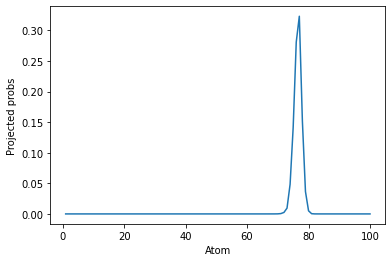

Episode 70: 	Actor Loss: -3.40 	Critic Loss: 2.86 
		Average Score: 14.54

SCORES (this eps):  [39.23998193 22.08133996 11.25461482  9.77362056  0.         10.32684018
 29.44484776 12.89947471  9.64604431 19.3962867  20.85882857 21.76665042] 



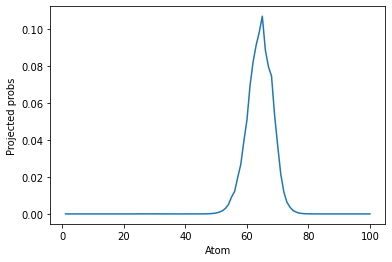

Episode 80: 	Actor Loss: -3.46 	Critic Loss: 2.83 
		Average Score: 18.25

SCORES (this eps):  [19.28110634  0.92689126 13.48911911 15.43507521 11.54258222 36.58917288
  9.36465623 44.95957095 26.10549306 32.3141777   7.30517905  6.50456852] 



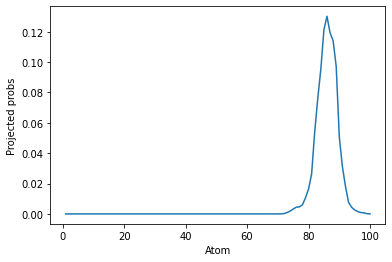

Episode 90: 	Actor Loss: -3.71 	Critic Loss: 2.84 
		Average Score: 23.39

SCORES (this eps):  [ 0.         47.23449485  0.21236733 16.65489489  5.58754459 23.38983357
 12.1356293   9.91852496 21.5843565   1.83436238 11.47808062 36.0345664 ] 



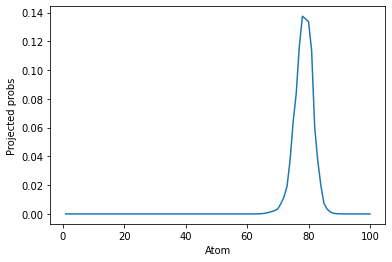

Episode 100: 	Actor Loss: -4.01 	Critic Loss: 2.86 
		Average Score: 20.64

SCORES (this eps):  [ 7.7057967   2.03580176  0.46628672  8.3969636  10.94821382 16.67783216
  6.15585068  0.26578383 44.53612778 54.20643388  2.64405899 37.91387901] 



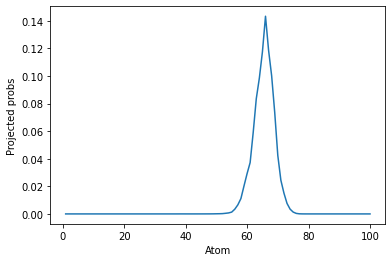

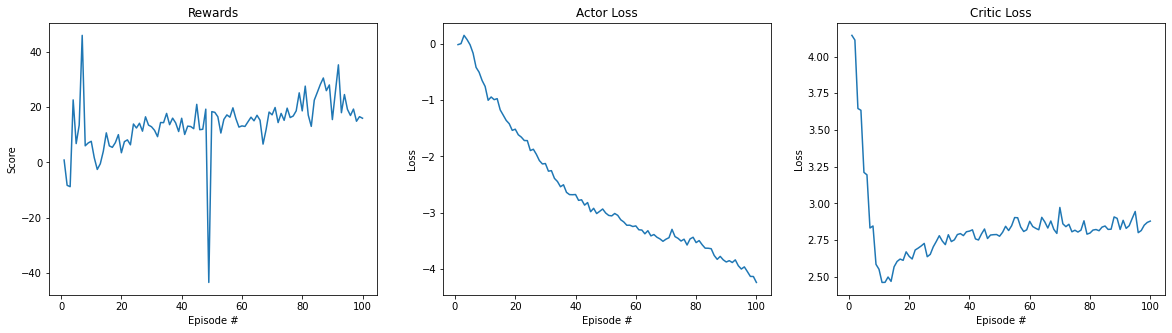

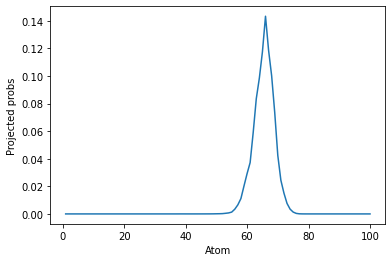

[0.8772191131477788,
 -8.271143450440528,
 -8.75354919861032,
 22.633520751978114,
 6.823762371845078,
 13.488521445697794,
 45.966911757617105,
 6.026027904260748,
 7.062678202909107,
 7.654501876638581,
 1.718315473680074,
 -2.522332686232403,
 -0.48252403584774584,
 4.027632837649435,
 10.707215216942132,
 5.9998286449893685,
 5.464391379966401,
 7.175048991067645,
 10.062593854342898,
 3.5108371449944875,
 7.528627692566563,
 8.173399994693076,
 6.382884453710479,
 13.905115671940925,
 12.462809284819135,
 14.178559257493665,
 11.315160984639078,
 16.510230293807883,
 13.52031784267941,
 12.903801568046523,
 11.617643889427805,
 9.329463933128864,
 14.445873635859849,
 14.398992758477107,
 17.741191952760953,
 13.659391130281923,
 16.028347268817015,
 14.321950314139636,
 11.185616904345807,
 15.988043711249096,
 10.127296096955737,
 13.139851822052151,
 12.991373631870374,
 12.2196360269445,
 21.01743327830142,
 11.846098882941684,
 12.00294992319929,
 19.27567651429369,
 -43.3891

In [26]:
##################
# Vmax = -Vmin = 10
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_10'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_10'
params.num_atoms = 100
params.vmin = -10
params.vmax = 10


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -20
VMAX:  20
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.00 	Critic Loss: 3.15 
		Average Score: -0.52

SCORES (this eps):  [-0.73062578  0.46301526  0.33236915  1.9418207   6.85292186  2.0642787
  1.83127954  7.40193838 15.27050787 10.61772952 -1.74969727  1.00144953] 



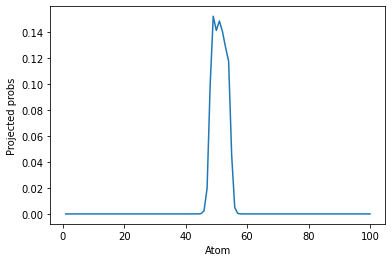

Episode 20: 	Actor Loss: -0.21 	Critic Loss: 1.68 
		Average Score: 1.96

SCORES (this eps):  [-0.39778248  2.37935225 -2.75069384  0.          2.33246436  0.
 28.7603595   0.          0.67138334 -4.43835725  0.13693545 -3.40263993] 



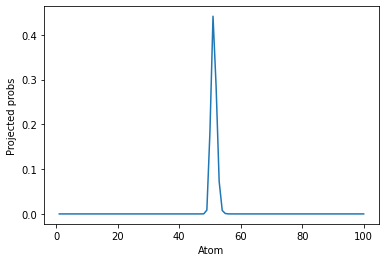

Episode 30: 	Actor Loss: -0.37 	Critic Loss: 1.59 
		Average Score: 1.98

SCORES (this eps):  [19.62325521  5.61333272  0.38503923  1.14367466  1.72667996 -0.77597512
  6.30990977  1.02179574  3.34672682  1.84221537  3.09520771  0.66070719] 



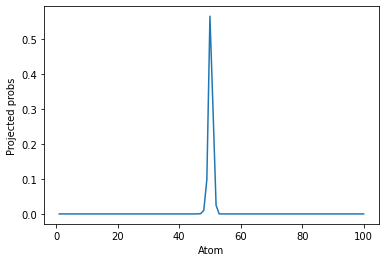

Episode 40: 	Actor Loss: -0.52 	Critic Loss: 1.63 
		Average Score: 5.41

SCORES (this eps):  [ 3.06934987 16.86180392 -3.86143779  5.57436052  7.27207953  1.24775032
  1.76446026  1.09648088  5.64519447  9.63185996  8.60549763  5.21582932] 



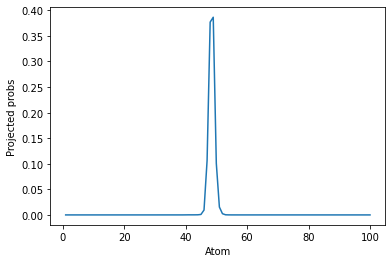

Episode 50: 	Actor Loss: -0.74 	Critic Loss: 1.72 
		Average Score: 7.76

SCORES (this eps):  [ 3.6637178   3.75316278  5.87247094  0.63084483 16.47609942  9.5657201
  4.99374331  0.531583   15.21698117  6.88961377  2.10580474  5.58425455] 



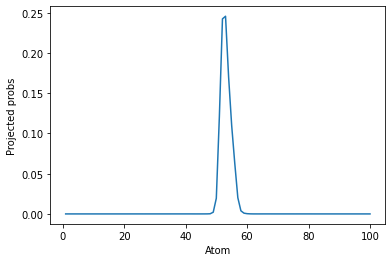

Episode 60: 	Actor Loss: -1.02 	Critic Loss: 1.79 
		Average Score: 8.66

SCORES (this eps):  [ 2.19947984 10.4217497   4.38584729  2.30718842  4.31184879 67.06763492
  0.53809574 23.68555629  0.          4.70323875  5.26782572 13.97110736] 



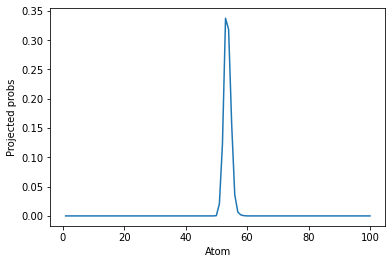

Episode 70: 	Actor Loss: -1.38 	Critic Loss: 1.90 
		Average Score: 9.73

SCORES (this eps):  [ 1.30883718  8.00632678  2.86311771  5.30503203  0.49246303  5.48084921
 11.65188168 25.24860219  8.52555893 11.11291874 15.85210652 11.61315867] 



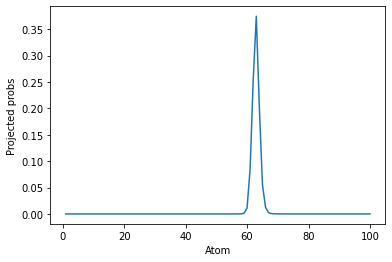

Episode 80: 	Actor Loss: -1.68 	Critic Loss: 1.94 
		Average Score: 13.21

SCORES (this eps):  [ 9.47962982  3.45457087 32.83419537  8.64257596  7.96032881 12.94724806
 25.36715601  3.00473477 20.22452457 10.04988719  0.42631844 13.98801376] 



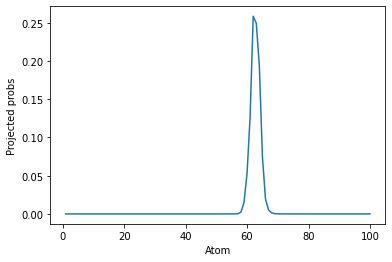

Episode 90: 	Actor Loss: -1.99 	Critic Loss: 1.99 
		Average Score: 11.54

SCORES (this eps):  [13.39324475  0.15636194 17.44859705  0.16982637  1.13580433  3.66945978
 24.76889814 36.50071334 13.43447639 39.85729359 12.84512484 13.39512964] 



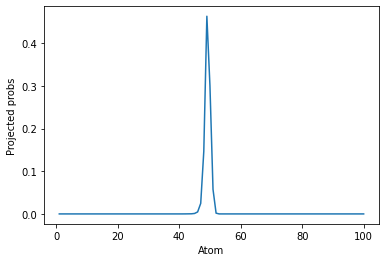

Episode 100: 	Actor Loss: -2.37 	Critic Loss: 2.04 
		Average Score: 16.17

SCORES (this eps):  [10.65587563  2.44950888 16.29844843 20.35430552 20.9332303   0.39662603
 23.30097235 19.23228537  6.02198975 20.41115729 28.94063883 47.24147447] 



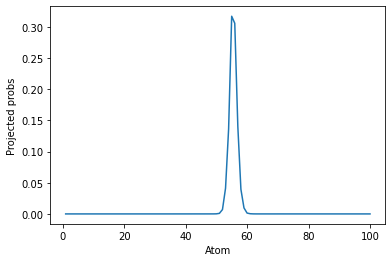

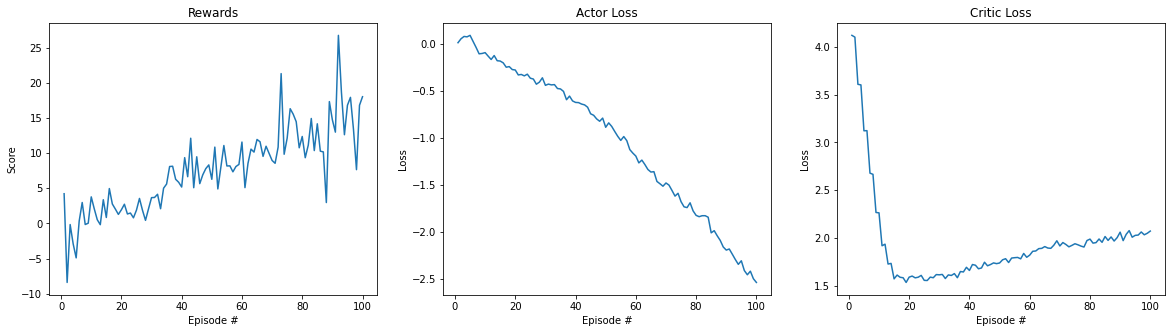

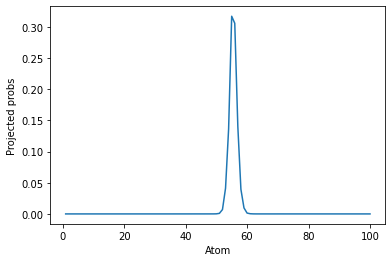

[4.224524705898754,
 -8.39553207330755,
 -0.16151179351921505,
 -2.903703821861806,
 -4.90036028578955,
 0.33910143468528986,
 2.9743369872157928,
 -0.15542751904771043,
 0.03201175994884883,
 3.7747489559696987,
 2.0775639509859807,
 0.5260925905313343,
 -0.18019736868639788,
 3.3691430111648515,
 0.8448219085500265,
 4.957834284364556,
 2.7623580006572106,
 2.0409010426374152,
 1.2839313455624506,
 1.9409184506318222,
 2.728440667366764,
 1.345002797471049,
 1.475723729216649,
 0.7986968098169503,
 1.8881226350010063,
 3.551914562432406,
 1.8757609314731478,
 0.43783818260514334,
 2.0755208577417457,
 3.6660474373202305,
 3.6920997799995043,
 4.144092821050435,
 2.0907658882788382,
 5.01093069636651,
 5.601687478968718,
 8.093187416355553,
 8.132278132834472,
 6.278549537955162,
 5.854188488893366,
 5.176935740940583,
 9.355685082632894,
 6.643333001974194,
 12.116203936709402,
 5.080181456267989,
 9.478495621743301,
 5.6574500714389915,
 6.908999722218141,
 7.7917312291295575,
 8.31

In [27]:
##################
# Vmax = -Vmin = 20
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_20'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_20'
params.num_atoms = 100
params.vmin = -20
params.vmax = 20


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  1
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.08 	Critic Loss: 4.02 
		Average Score: -0.60

SCORES (this eps):  [  8.01517027   6.48406217  -2.75612858 -12.64666858  25.20109191
 -21.99321894 -26.9668658    8.26694862  -0.09087685  20.12881933
   2.2583941  -34.58130432] 



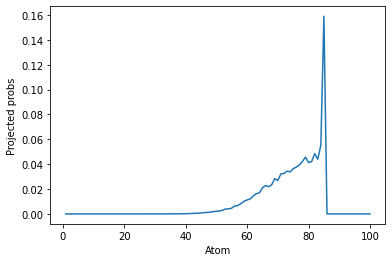

Episode 20: 	Actor Loss: -0.12 	Critic Loss: 3.89 
		Average Score: -0.43

SCORES (this eps):  [-4.97008981  1.95355826  1.40890478  0.         13.41645721  6.23558551
  0.4360254   1.52359001  4.03561327  7.63296215 -4.02011383  0.        ] 



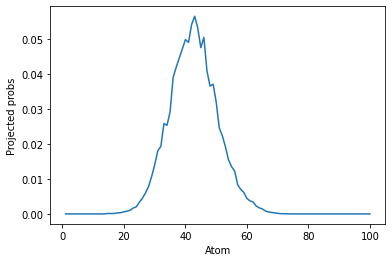

Episode 30: 	Actor Loss: -0.23 	Critic Loss: 3.53 
		Average Score: 3.91

SCORES (this eps):  [ 8.90157521 12.20458168 11.35367103  4.19726375  6.21686297  1.70222394
  0.85783017  3.66014106  1.48589117 10.83525407 12.89773459  4.18672938] 



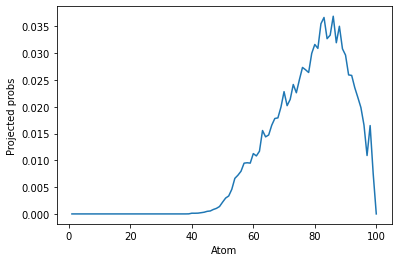

Episode 40: 	Actor Loss: -0.32 	Critic Loss: 3.28 
		Average Score: 6.40

SCORES (this eps):  [ 3.315421    4.69789003  4.02645117  3.61164028 15.24553119 15.23042482
  4.22482263  3.15090067  6.20390144  8.5078827   2.05965219  9.53759919] 



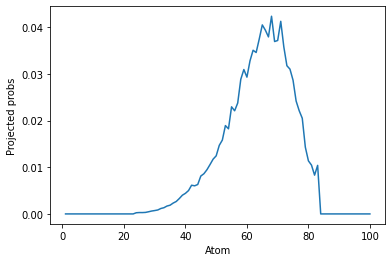

Episode 50: 	Actor Loss: -0.40 	Critic Loss: 3.11 
		Average Score: 10.95

SCORES (this eps):  [ 7.36383173 10.16062493  7.83878212  0.41718042 28.48645155 23.0851019
 12.23992347 39.1864989   6.56126074 12.76960032  4.40947911  2.55282361] 



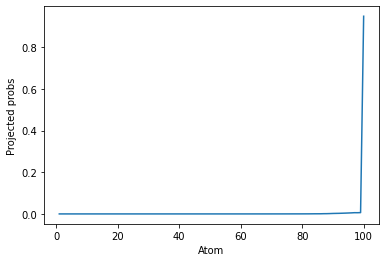

Episode 60: 	Actor Loss: -0.46 	Critic Loss: 2.92 
		Average Score: 10.41

SCORES (this eps):  [40.10589591  6.83877345  0.2084822   1.4297581  12.2736525  23.26145469
  7.44246621 43.68986807  5.20495005 32.69029714 11.62604002  2.61709133] 



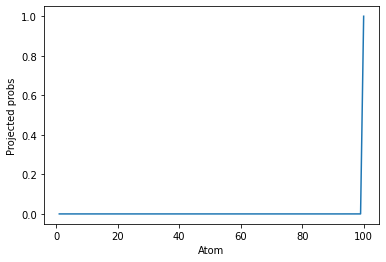

Episode 70: 	Actor Loss: -0.51 	Critic Loss: 2.74 
		Average Score: 13.68

SCORES (this eps):  [ 0.62356542  8.25292864  4.61186321 23.26649903  7.7726746  21.6822681
 14.09199604 11.67389294  6.48188841  8.38583825 23.39313478 67.41105078] 



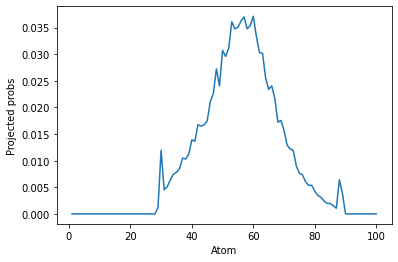

Episode 80: 	Actor Loss: -0.54 	Critic Loss: 2.65 
		Average Score: 16.29

SCORES (this eps):  [ 5.70546439 71.63685645  8.39717492  3.32171958 20.87954327 36.47006667
 40.45659443  5.38636648 59.58715333  2.77411908 10.42691134  6.91912031] 



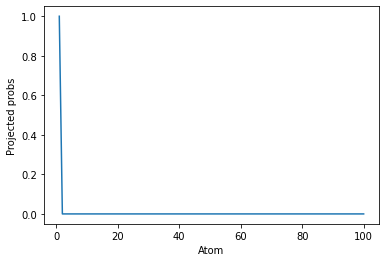

Episode 90: 	Actor Loss: -0.59 	Critic Loss: 2.42 
		Average Score: 20.79

SCORES (this eps):  [12.78132495 23.44807268 37.54011793 38.63372962  4.9543417   3.50528567
 14.53610637  6.32622955 16.7959347   4.14679977  7.31596852 15.14644239] 



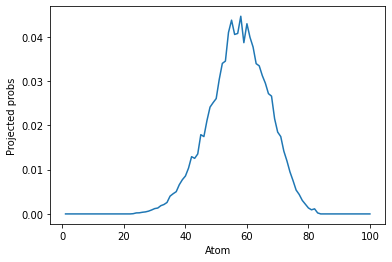

Episode 100: 	Actor Loss: -0.66 	Critic Loss: 2.04 
		Average Score: 25.55

SCORES (this eps):  [11.09623839  5.46180243  6.3832874  21.80794947 81.47162403 50.21488556
 18.02012903 69.31902625  8.53488011  3.65683538 19.60959193 27.1297087 ] 



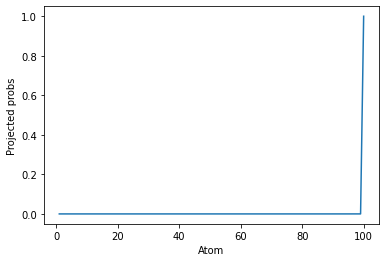

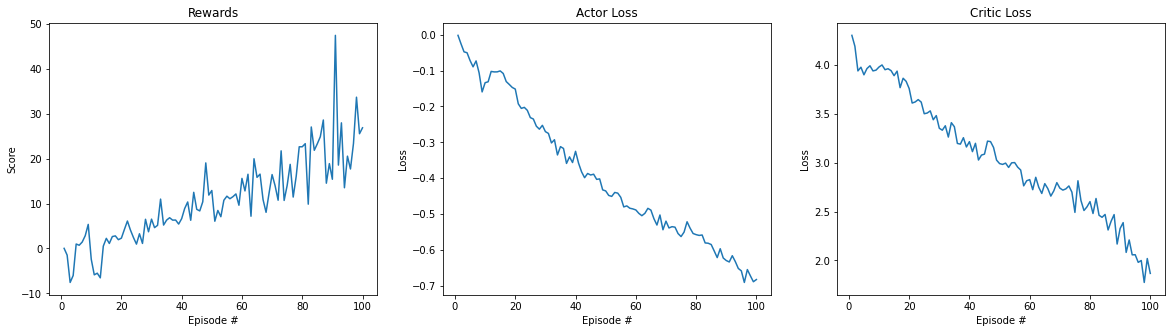

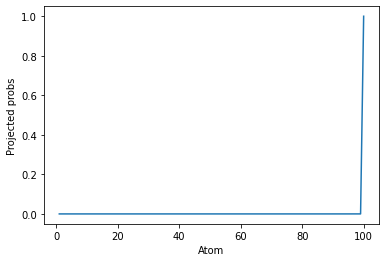

[0.03207848084275611,
 -1.474068019791351,
 -7.563114530062497,
 -6.020841776781405,
 0.9981714589521289,
 0.7232401491686081,
 1.4375345967321966,
 2.8472941190023753,
 5.36899702163646,
 -2.3900480566517217,
 -5.86533207220297,
 -5.499730483114642,
 -6.536568251218948,
 0.5285677599022165,
 2.259750133360891,
 1.124830438162462,
 2.662453904078575,
 2.8072735615908946,
 1.9626926834656235,
 2.3043744126916863,
 4.244624494002589,
 6.121337632512829,
 4.121901134620809,
 2.4536062510014744,
 0.9763891185478618,
 3.2811003157742866,
 1.1282137727345496,
 6.508356589481991,
 3.729079146811273,
 6.541646583815843,
 4.6469159257248975,
 5.160705070748615,
 11.004279018753246,
 5.226514603535179,
 6.323594570159912,
 6.857574635146496,
 6.32060444977833,
 6.338926599593833,
 5.445784834202641,
 6.651009775416848,
 8.917298240897557,
 10.364468775544083,
 6.2901761636312585,
 12.516604505023375,
 8.727924794501936,
 8.374164807062092,
 10.404999032150954,
 19.067548851055715,
 11.8978601547

In [28]:
##################
# Vmax = -Vmin = 1
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_1'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_1'
params.num_atoms = 100
params.vmin = -1
params.vmax = 1


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.5
VMAX:  0.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.08 	Critic Loss: 2.49 
		Average Score: -3.16

SCORES (this eps):  [ 0.          2.08782317 -1.00095013  0.81460006  3.26481951 -4.67749704
  3.77535623  7.10588116  0.36963854 -9.4944245  -1.56890606 -1.73609999] 



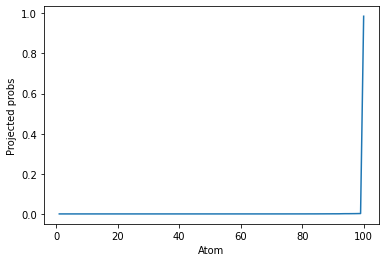

Episode 20: 	Actor Loss: -0.05 	Critic Loss: 2.95 
		Average Score: 2.70

SCORES (this eps):  [-12.74444548  -4.58289458   3.39552583  -2.2822616    0.07021045
  -8.3123256    3.77758837   0.42694323   1.27485519   9.0144441
  -4.83611555   0.55555914] 



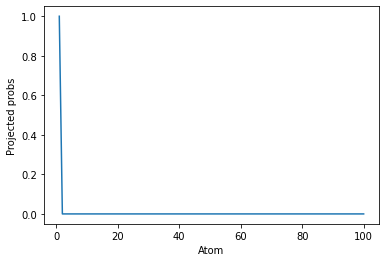

Episode 30: 	Actor Loss: -0.07 	Critic Loss: 3.15 
		Average Score: 6.33

SCORES (this eps):  [ 7.53040468  2.26885952 17.65001691 13.37028617 19.12084868  8.51160576
 35.15502565  1.96120629  3.27832633 11.23947764 18.90539927 11.85707678] 



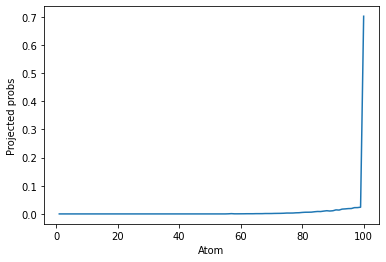

Episode 40: 	Actor Loss: -0.12 	Critic Loss: 3.19 
		Average Score: 15.16

SCORES (this eps):  [ 2.42933773  0.79576406  0.73716448 17.44186701  5.76792971  1.96595355
 10.09424541 20.51709608  3.66498304  0.52929427  7.6215971   7.64935621] 



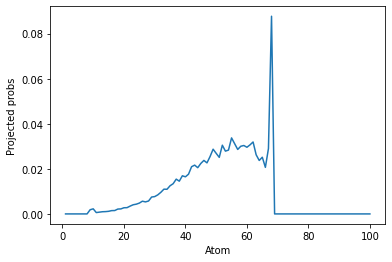

Episode 50: 	Actor Loss: -0.18 	Critic Loss: 3.10 
		Average Score: 9.03

SCORES (this eps):  [ 7.59603768  2.37391086 11.32382649  2.79028006  6.45693567  4.52815213
  8.01721119  6.44965946 19.51746362  2.19583691  6.87357103  1.38971202] 



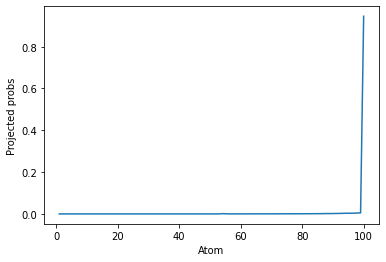

Episode 60: 	Actor Loss: -0.22 	Critic Loss: 2.93 
		Average Score: 7.87

SCORES (this eps):  [ 4.40461092  0.87932106  0.78319871 14.24754792 18.6496637   2.73461553
  1.62910944  4.20839138  2.72188458 10.93611463  3.3401519  24.53075453] 



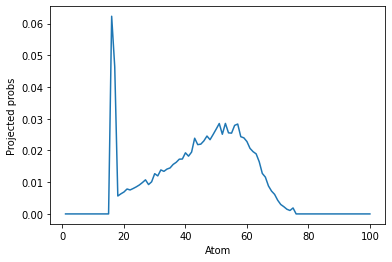

Episode 70: 	Actor Loss: -0.25 	Critic Loss: 2.74 
		Average Score: 11.28

SCORES (this eps):  [ 3.73862544  2.60770692  4.19492464 29.60669896 24.56057264 34.16017983
 33.5409155   2.1727012  23.08813561 14.7621641  15.5911882  25.57229645] 



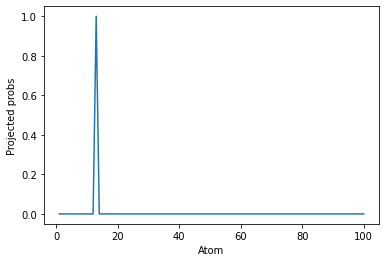

Episode 80: 	Actor Loss: -0.29 	Critic Loss: 2.53 
		Average Score: 16.70

SCORES (this eps):  [44.21041201 19.85175499 18.98166302 11.76859746 18.57979172 37.57628345
  5.51291662 42.4676744  32.63909574  7.89289355 12.36531476 17.19578388] 



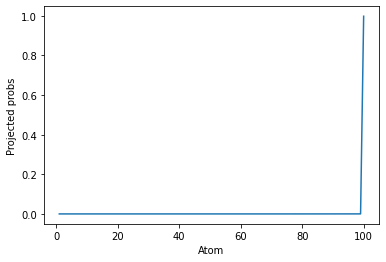

Episode 90: 	Actor Loss: -0.32 	Critic Loss: 2.37 
		Average Score: 25.06

SCORES (this eps):  [  9.002796    17.0787252   11.45765697  18.45830677 104.80464918
  23.09941681  42.16023502  14.82315836  20.19770162  13.56117364
  70.03814526  64.36001914] 



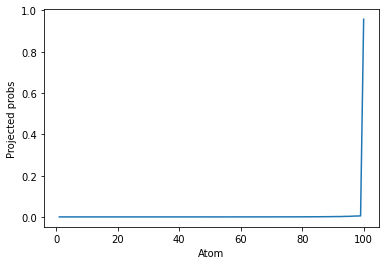

Episode 100: 	Actor Loss: -0.35 	Critic Loss: 2.11 
		Average Score: 50.60

SCORES (this eps):  [  1.31715403  42.97949543 141.73019979 142.39325715  57.34276628
  15.84153893 122.38722862  62.01106206  76.4860307   20.61805017
  31.75904738 133.1338641 ] 



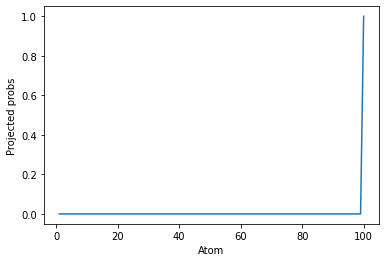

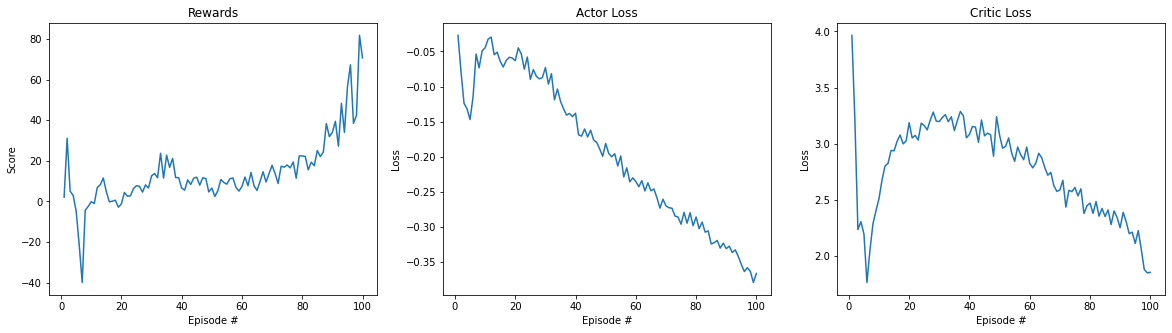

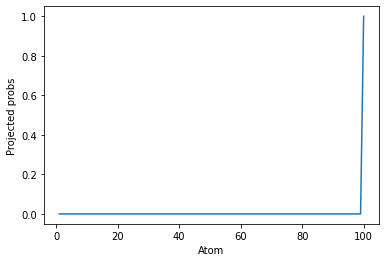

[2.129581238805258,
 31.08678520747344,
 5.052751330619988,
 3.0091456145358584,
 -4.844684168832221,
 -21.29970469334997,
 -39.870663065245026,
 -4.343843388812577,
 -2.413333450250017,
 -0.08831325512922679,
 -1.0278445339984803,
 6.872994544634518,
 8.254887373961537,
 11.575737388021176,
 4.833358791511273,
 -0.1923285304607513,
 0.14177891674141088,
 0.608855165153121,
 -2.8414267011685297,
 -1.186909708068318,
 4.458836241921138,
 2.568832735923934,
 2.798363227843462,
 6.302520966487161,
 7.775913385751967,
 7.445548876596149,
 4.61230750879137,
 8.148247654588582,
 6.63136541043059,
 12.57071114044326,
 13.766142065792033,
 11.670328284890275,
 23.748363646610716,
 11.526086740586228,
 22.813781291756943,
 16.76934934307792,
 21.192338768477686,
 11.748180086763265,
 11.734608538952065,
 6.601215721275366,
 5.568235772427822,
 10.612569964844928,
 8.390497012221507,
 11.454486415658417,
 11.9671995679455,
 8.041695197597923,
 11.655700049091442,
 11.333824299302554,
 4.67995540

In [29]:
##################
# Vmax = -Vmin = 0.5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.5'
params.num_atoms = 100
params.vmin = -0.5
params.vmax = 0.5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -3
VMAX:  3
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.31 	Critic Loss: 3.71 
		Average Score: 4.58

SCORES (this eps):  [ 0.58396529  1.0296138   4.92815056  0.76412331 19.10368703  0.45806252
  0.1385428   0.42352421  0.61107032  0.96083194  0.59809611 27.73643821] 



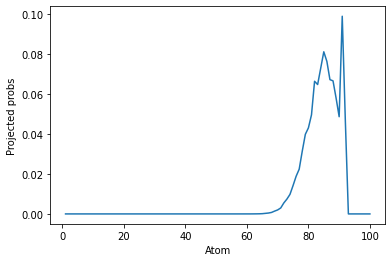

Episode 20: 	Actor Loss: -0.71 	Critic Loss: 3.49 
		Average Score: 6.67

SCORES (this eps):  [ 2.89952437 26.38051365  4.51971888 18.9072589   1.58700826  0.2332052
  0.18936073 36.87048025  2.60537294  9.39909129  0.          2.80489299] 



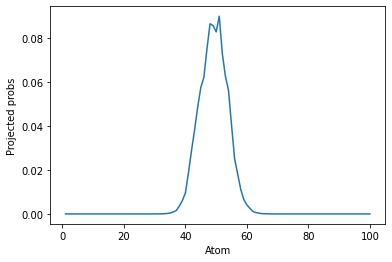

Episode 30: 	Actor Loss: -1.26 	Critic Loss: 3.24 
		Average Score: 15.17

SCORES (this eps):  [ 2.88920881 32.70653648 14.30052326  5.93961219  0.06014626  3.9394429
  7.00643639 37.46380475 32.33754491  2.83740846 14.20339818 34.54401035] 



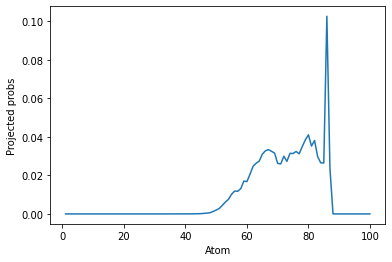

Episode 40: 	Actor Loss: -1.65 	Critic Loss: 2.91 
		Average Score: 17.58

SCORES (this eps):  [14.00867043  0.69958828 29.68590619 12.85219121  5.9247587  17.40327279
 16.50832764  9.10020412 23.97747803 30.8098438  12.86888339  2.97876586] 



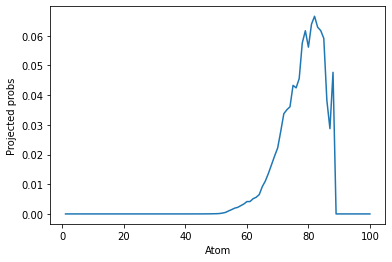

Episode 50: 	Actor Loss: -1.86 	Critic Loss: 2.58 
		Average Score: 34.76

SCORES (this eps):  [  0.25745793  98.96725256 122.05411618   7.3763481  102.75382429
   2.82689134 113.32301861   1.63483436  39.3896426   44.1830127
  46.7069297   24.45222302] 



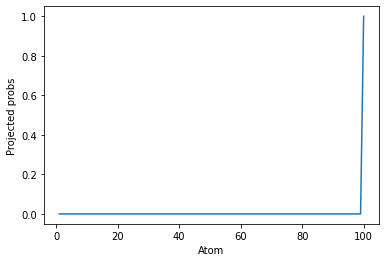

Episode 60: 	Actor Loss: -2.00 	Critic Loss: 2.41 
		Average Score: 35.15

SCORES (this eps):  [83.19988944  0.65596654  4.58019344  3.0482455  11.19690377 11.07524224
 21.09365833 20.55333125 12.32097646 41.68848964 37.83105752 29.68579405] 



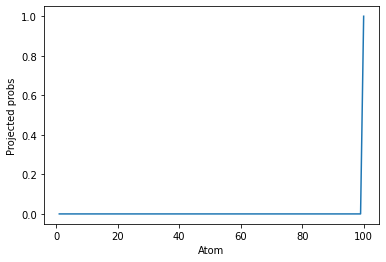

Episode 70: 	Actor Loss: -2.09 	Critic Loss: 2.28 
		Average Score: 28.43

SCORES (this eps):  [ 24.01710785  38.02898312  36.95220003  16.0699624   54.53047862
  14.17270804  28.34623902   0.62028073 129.0136482   25.27802359
   5.25620563  12.55219827] 



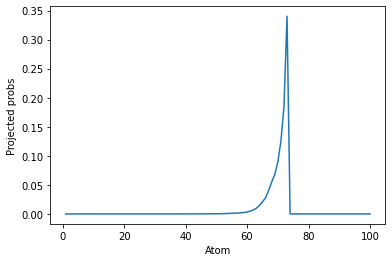

Episode 80: 	Actor Loss: -2.19 	Critic Loss: 2.10 
		Average Score: 33.09

SCORES (this eps):  [ 38.05142353   3.02730985   0.44221269   0.          75.99546677
 119.5351369    2.64994369  44.65880429  20.64938729   6.49249151
  93.17810523  77.7918313 ] 



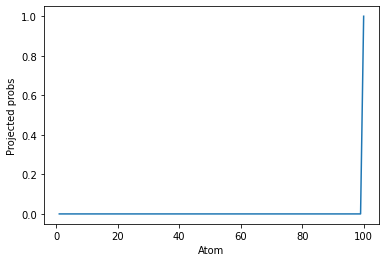

Episode 90: 	Actor Loss: -2.29 	Critic Loss: 1.96 
		Average Score: 31.06

SCORES (this eps):  [33.52272355 12.20488627 71.61732294 44.67192788  6.89496731 21.05743587
 41.22647677  0.41300453 41.33175773 91.89145215 49.70516511 61.49254266] 



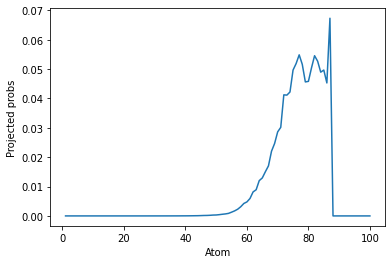

Episode 100: 	Actor Loss: -2.47 	Critic Loss: 1.69 
		Average Score: 34.55

SCORES (this eps):  [94.73088777 29.46077923 80.1161993  22.78425137 34.47056279 81.95186707
 17.27447583  1.87351729 14.27833401 44.44819472 33.88176187 43.3975274 ] 



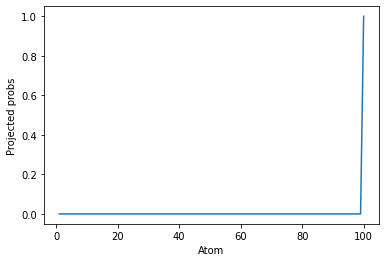

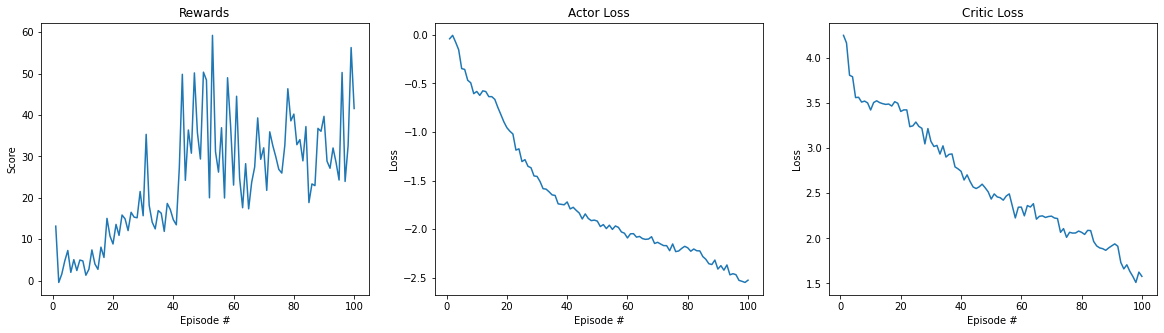

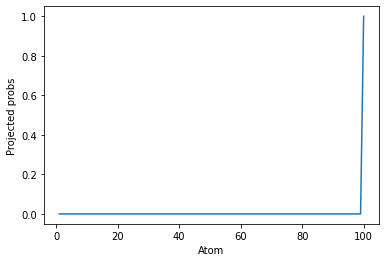

[13.169618048123084,
 -0.41426967195487424,
 1.5983409230830148,
 4.7832698970257,
 7.294767836710283,
 2.0241556794693074,
 5.082918498199433,
 2.461980660834039,
 4.9901577772106975,
 4.778008842481843,
 1.3250028955905389,
 2.763841016800143,
 7.433034607985367,
 4.037255522911437,
 2.7482100050353133,
 8.102181453839876,
 5.619202231571156,
 15.049098140831726,
 10.77614481432829,
 8.866368953313213,
 13.589215234310055,
 10.940940232287781,
 15.854547524979958,
 14.932638250058517,
 12.097034174395958,
 16.513735306449234,
 15.34718047749872,
 15.19414489363165,
 21.535539337666705,
 15.685672746660808,
 35.3197851445002,
 18.189070709592972,
 14.127385993604548,
 12.5106472656286,
 16.92719651547183,
 16.287717697404634,
 11.906933251574324,
 18.648703011878144,
 17.190674034024898,
 14.7348242016742,
 13.494346543874903,
 27.305371957850486,
 49.808689688681625,
 24.223362917546183,
 36.369713431146614,
 30.773604653930914,
 50.14400684086528,
 35.741651912763096,
 29.3693384964

In [30]:
##################
# Vmax = -Vmin = 3
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_3'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_3'
params.num_atoms = 100
params.vmin = -3
params.vmax = 3


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -7.5
VMAX:  7.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: 0.02 	Critic Loss: 3.33 
		Average Score: 0.53

SCORES (this eps):  [2.47768446 2.30408969 0.19712734 2.08607591 0.76365248 2.02072234
 0.39811182 2.04685278 0.71980869 0.60489631 6.67384455 0.40070391] 



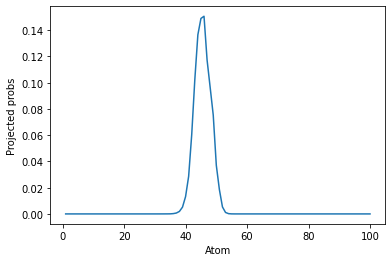

Episode 20: 	Actor Loss: -0.25 	Critic Loss: 2.47 
		Average Score: 3.36

SCORES (this eps):  [ 0.64238304  7.0332646   0.67024481  2.98530058  0.74273335  6.18430234
 15.1928294   3.41470279 -3.97392953 -0.88777342  0.79964198  0.09135   ] 



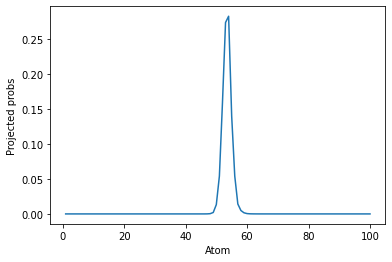

Episode 30: 	Actor Loss: -0.40 	Critic Loss: 2.47 
		Average Score: 5.25

SCORES (this eps):  [ 1.72528776 13.8561957   0.76101594  1.85832517 12.46746817  0.60278357
  4.74868088  7.96711928  9.41961751 11.23387094  0.91547409 19.15064202] 



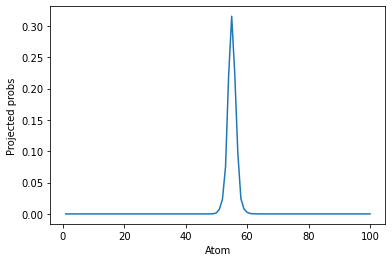

Episode 40: 	Actor Loss: -0.57 	Critic Loss: 2.52 
		Average Score: 3.25

SCORES (this eps):  [1.52298517 0.8622725  0.80383871 1.22345015 0.04927734 0.72354341
 0.54277528 0.28296314 0.2490248  0.29767983 6.20494063 1.64375721] 



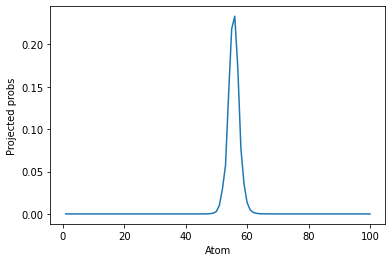

Episode 50: 	Actor Loss: -0.83 	Critic Loss: 2.64 
		Average Score: 4.83

SCORES (this eps):  [18.60571968  2.93070757 -2.94256163 29.26772715  2.1814213   9.78608062
  7.60497975  2.64428772  2.62515096  5.24593026 -0.12307986  0.21416164] 



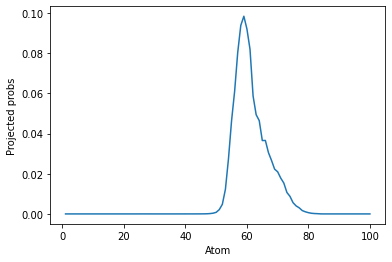

Episode 60: 	Actor Loss: -1.03 	Critic Loss: 2.74 
		Average Score: 7.91

SCORES (this eps):  [9.22044206e-01 1.24553768e-02 2.35240448e+01 6.92299560e+00
 2.75822095e+01 9.25593683e-01 1.61208897e+01 4.67594092e+00
 1.50212934e+01 4.49684234e+00 2.56039418e+00 6.03703069e-01] 



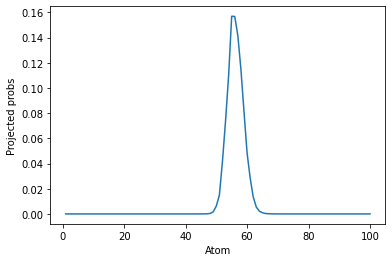

Episode 70: 	Actor Loss: -1.24 	Critic Loss: 2.80 
		Average Score: 10.12

SCORES (this eps):  [ 1.54354115e+01  1.77004722e+01  3.49509373e-01  1.05803128e+01
  1.02564586e+01  3.54382709e+00  6.16186098e+00  1.06768016e+01
  2.97785446e+00 -3.85224819e-04  2.01175511e-02  9.85295134e+00] 



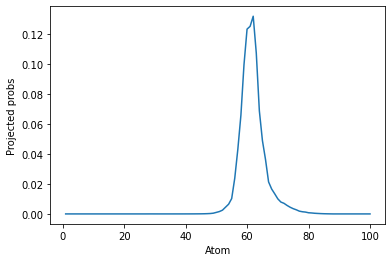

Episode 80: 	Actor Loss: -1.40 	Critic Loss: 2.85 
		Average Score: 12.18

SCORES (this eps):  [22.07072837  6.44604998 25.73697478  7.05140024  7.47527749  0.99673755
  7.88475678  0.59184883 19.40642118  0.81330593 15.10447583 46.48201056] 



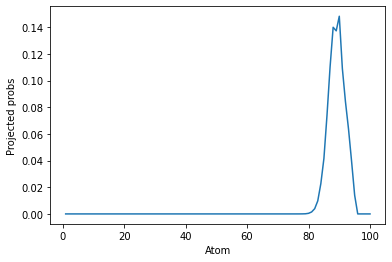

Episode 90: 	Actor Loss: -1.71 	Critic Loss: 2.93 
		Average Score: 15.07

SCORES (this eps):  [ 5.52720034 28.44660227  0.24335442 19.7838152  17.7730032   4.93159534
  2.08597222  2.38771456  4.84773907 10.8031294  32.11568615  0.4625996 ] 



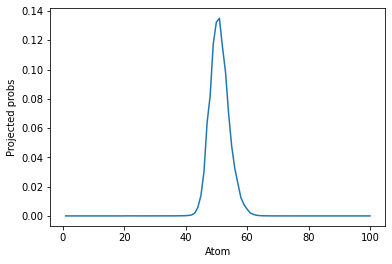

Episode 100: 	Actor Loss: -2.08 	Critic Loss: 2.97 
		Average Score: 23.90

SCORES (this eps):  [1.59934957e-01 5.45219004e+00 9.95920312e+01 5.40575626e+00
 6.31663102e+00 1.46422839e-01 1.73117546e+00 7.17506651e-02
 1.97110716e+01 1.77468951e+01 2.54083256e+00 0.00000000e+00] 



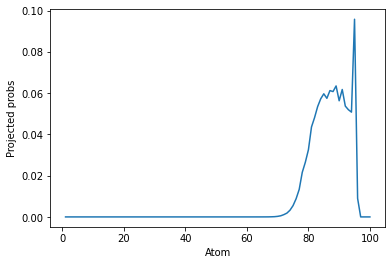

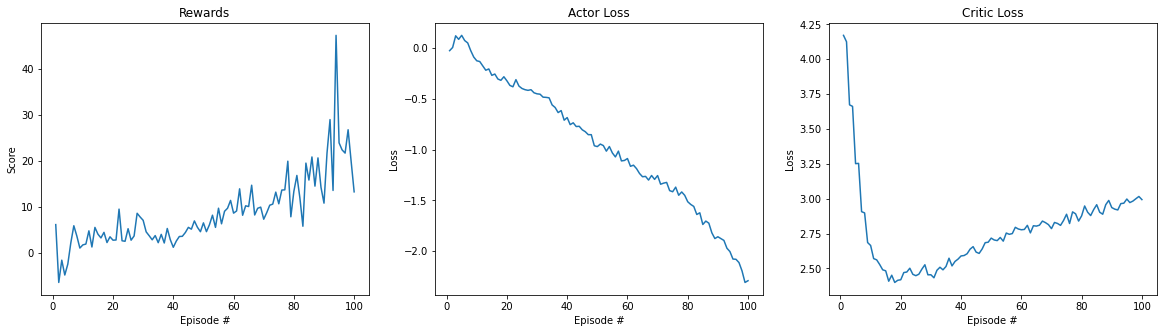

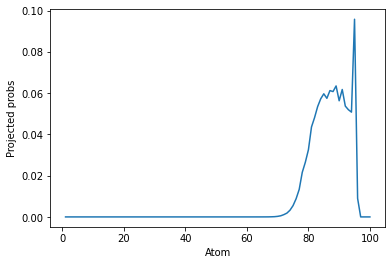

[6.123749904480064,
 -6.43038972299352,
 -1.5966937646492927,
 -4.81802414553628,
 -2.4549823994457256,
 2.1629926102068566,
 5.877693699595208,
 3.645824313396588,
 1.031756986087809,
 1.7244641905417666,
 1.9027889449304591,
 4.772803692554589,
 1.2687923888249013,
 5.518752059064961,
 4.045506257816062,
 3.2332097845695293,
 4.4438139831957715,
 2.231405749664797,
 3.476699148837118,
 2.741254162399855,
 2.7859316192819583,
 9.486706891936288,
 2.6151587911735987,
 2.5078202080003393,
 5.234449502701561,
 2.7459907181037124,
 3.6677970706659835,
 8.58423034681861,
 7.778752112450699,
 7.058873419484978,
 4.5506109484122135,
 3.712381262642642,
 2.8270694869182385,
 3.745540185753877,
 2.2007086638283604,
 4.00374435451037,
 2.1351804486863935,
 5.282713610494587,
 2.867637370189186,
 1.2005423475056887,
 2.558757231628988,
 3.5417359001003206,
 3.5865776255959645,
 4.407623362805073,
 5.5277650110656396,
 5.138256510319479,
 6.926160340507825,
 5.552647890639491,
 4.587769641725269,

In [31]:
##################
# Vmax = -Vmin = 7.5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_7.5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_7.5'
params.num_atoms = 100
params.vmin = -7.5
params.vmax = 7.5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.1
VMAX:  0.1
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.04 	Critic Loss: 0.92 
		Average Score: 6.97

SCORES (this eps):  [-0.94756257  5.79682834 -8.33892053  0.01677716 -1.80458871  0.1205317
 -4.2834417  -3.30157089 -2.90149866  7.30100595  2.93315669  1.13324125] 



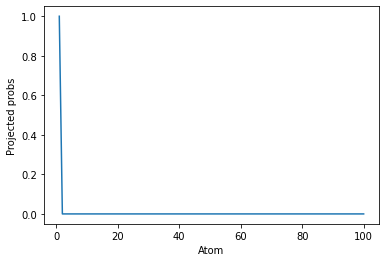

Episode 20: 	Actor Loss: -0.02 	Critic Loss: 0.86 
		Average Score: -6.53

SCORES (this eps):  [  5.43210332  -1.72368333 -11.39298778 -12.05446629  -8.13776714
  -3.80050093   5.42794953  18.98958824   8.77740922 -18.60404532
  -9.63278925  -4.33970081] 



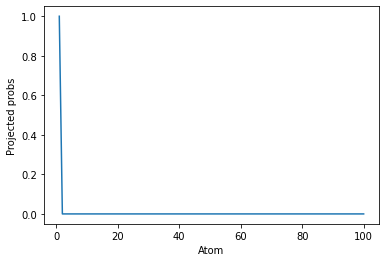

Episode 30: 	Actor Loss: -0.02 	Critic Loss: 1.02 
		Average Score: 0.56

SCORES (this eps):  [-12.87615171   0.90856028  -1.84614228  -0.94626231  -2.59678759
  -6.5348048  -10.02878148   0.87922746  -1.34044729   0.61096436
  -1.38826074   5.97377045] 



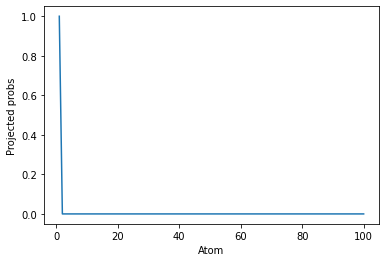

Episode 40: 	Actor Loss: -0.02 	Critic Loss: 1.02 
		Average Score: 0.34

SCORES (this eps):  [ 3.59819445  0.77243601 -2.61079567  0.06279051  0.53343935  5.08701501
  4.51691837  0.53135859  0.11039192  2.69861049  1.40557003 10.98558758] 



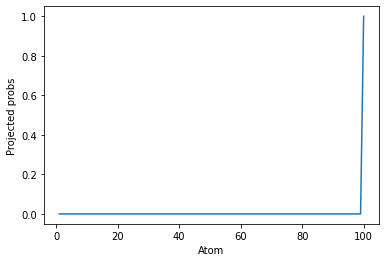

Episode 50: 	Actor Loss: -0.03 	Critic Loss: 0.97 
		Average Score: 2.81

SCORES (this eps):  [0.34043666 1.96652041 2.00267188 1.21579943 1.97583832 2.38713976
 6.78844178 8.90098915 0.23566347 7.44064786 4.25690482 2.27641981] 



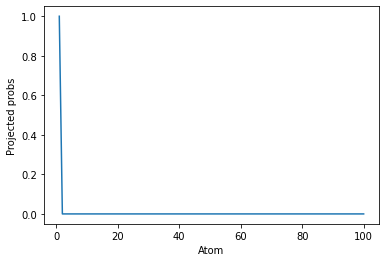

Episode 54\ Score: 1.77

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([0.5346, 0.5349, 0.5410, 0.5794, 0.6276, 0.5746, 0.5855, 0.5827, 0.5768,
        0.5671, 0.5346, 0.5519, 0.5386, 0.5365, 0.5348, 0.5352, 0.5350, 0.5346,
        0.5486, 0.5410, 0.5374, 0.5352, 0.5353, 0.5387, 0.5431, 0.5393, 0.5579,
        0.5354, 0.5378, 0.5346, 0.5372, 0.5405, 0.5454, 0.5424, 0.5353, 0.5354,
        0.5350, 0.5362, 0.5504, 0.5445, 0.5541, 0.5409, 0.5346, 0.5346, 0.5410,
        0.5346, 0.5494, 0.5403, 0.5383, 0.5364, 0.5359, 0.5390, 0.5411, 0.5375,
        0.5417, 0.5352, 0.5377, 0.5346, 0.5360, 0.5373, 0.5427, 0.5426, 0.5348,
        0.5351, 0.5359, 0.5376, 0.5537, 0.5407, 0.5442, 0.5394, 0.5346, 0.5346,
        0.5363, 0.5346, 0.5520, 0.5405, 0.5380, 0.5357, 0.5359, 0.5413, 0.5388,
        0.5373, 0.5401, 0.5354, 0.5367, 0.5346, 0.5355, 0.5448, 0.5428, 0.5414,
        0.5353, 0.5358, 0.5352, 0.5350, 0.5434, 0.5405, 0.5395, 0.5380, 0.534

Critic/bn1.bias Parameter containing:
tensor([ 5.2053e-02,  2.0952e-02, -1.5467e-02,  2.3899e-02, -1.1610e-02,
         7.4280e-03,  1.8805e-01,  2.7103e-02, -9.8006e-02,  6.6704e-02,
         2.7525e-02, -9.1142e-02, -1.1129e-01, -1.8348e-02, -3.5026e-03,
        -4.3888e-02,  5.8884e-02,  1.4079e-02,  6.7331e-02, -6.8108e-03,
         1.8749e-01,  4.9626e-02,  5.2648e-02,  7.6761e-02,  1.5861e-01,
         2.6168e-01, -9.6042e-02, -2.5806e-02, -3.3082e-02,  3.0455e-02,
         7.6882e-02,  5.3600e-02,  5.2040e-02, -2.4521e-02,  2.7987e-03,
        -3.0641e-02, -2.0996e-02, -9.7458e-02, -1.4047e-01,  5.5277e-02,
        -6.4864e-02,  1.0849e-01,  2.5686e-02,  3.5209e-02, -7.0233e-02,
         6.1165e-02,  4.8854e-02,  3.6306e-02,  3.9597e-02, -7.0249e-02,
         1.8309e-04, -8.4198e-03, -3.9588e-02,  3.8281e-02,  1.1003e-02,
        -1.1143e-01, -1.3853e-01,  1.6535e-02,  9.4515e-03, -7.7184e-02,
         7.0222e-02, -5.1153e-02, -5.0381e-03,  7.5631e-02, -5.0969e-02,
        -2.84

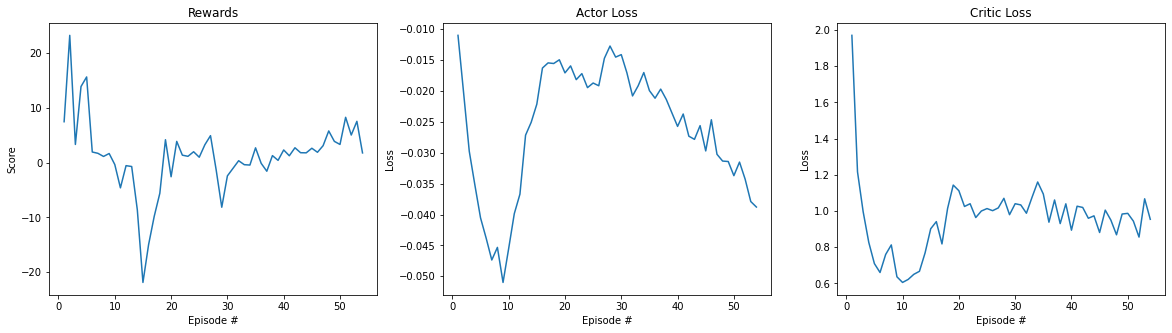

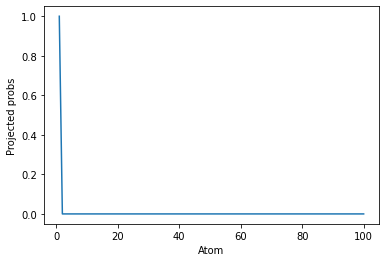

[7.469194573825614,
 23.253153988179594,
 3.3159084873429188,
 13.904195552449286,
 15.652415883130743,
 1.9351660708974425,
 1.6969722212525085,
 1.1226259041577578,
 1.6585888878131907,
 -0.3563368311927964,
 -4.615814999948877,
 -0.5600575836530576,
 -0.7167331444021935,
 -8.621466335452473,
 -21.903968302271096,
 -15.019650448632698,
 -9.839239315978679,
 -5.603920027373533,
 4.178790398713318,
 -2.588240878918441,
 3.8748047751626777,
 1.3560213817108888,
 1.1476187383717236,
 1.9820111744920723,
 0.981998452412275,
 3.2619726205787933,
 4.922567370629015,
 -1.2960883605313331,
 -8.15874093818517,
 -2.4320929694416313,
 -1.0445585100872752,
 0.34108469980613637,
 -0.3832383491098881,
 -0.45148619334213436,
 2.6966043045201027,
 -0.13499340469328067,
 -1.5781607686173327,
 1.2752614832522038,
 0.40939878034987487,
 2.3076263856686032,
 1.2501075464921694,
 2.709665880751951,
 1.8045460631450017,
 1.783770779108939,
 2.6217652272995715,
 1.8860525060736109,
 3.0911117685803524,
 5.7

In [32]:
##################
# Vmax = -Vmin = 0.1
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.1'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.1'
params.num_atoms = 100
params.vmin = -0.1
params.vmax = 0.1


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.25
VMAX:  0.25
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.04 	Critic Loss: 1.83 
		Average Score: 1.10

SCORES (this eps):  [ 0.58791866  2.69589556  5.02184226  2.57364848 29.25243833  5.68175721
  0.07554481 -0.22656945  0.52121231  1.70495737  6.65312792  0.31664857] 



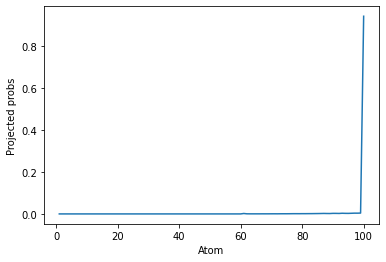

Episode 20: 	Actor Loss: -0.06 	Critic Loss: 1.63 
		Average Score: 0.65

SCORES (this eps):  [-2.06330587  0.99455159  1.69675348  0.54837577  0.14893599  2.19251914
  0.11651315  2.98755234  0.77289309  2.61388184  0.3736462  -1.6054482 ] 



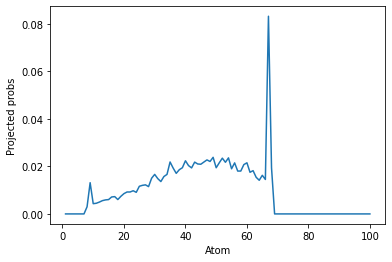

Episode 30: 	Actor Loss: -0.06 	Critic Loss: 2.16 
		Average Score: -4.28

SCORES (this eps):  [ 13.57967332  12.81993597 -14.13146284  10.74281829  10.6169815
   2.49648269   1.60690722  -1.82116981  11.27849647   4.06381451
   6.24416986   3.44490858] 



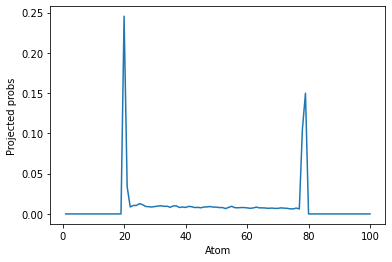

Episode 40: 	Actor Loss: -0.07 	Critic Loss: 2.33 
		Average Score: 12.39

SCORES (this eps):  [ 7.65902088 39.42717404 18.79854573  0.41950665  7.78723551 29.04964539
 13.14972099 16.58184128  1.70834328 38.42843119  3.64078532  6.3330828 ] 



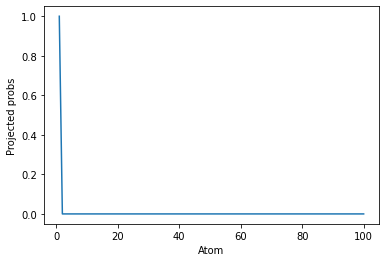

Episode 50: 	Actor Loss: -0.10 	Critic Loss: 2.32 
		Average Score: 23.93

SCORES (this eps):  [ 4.00874013 51.09069383 62.21216063 44.42022512 52.623658    4.20790923
 17.56769732 10.38538145 29.71666278 58.58523004  0.         24.85883167] 



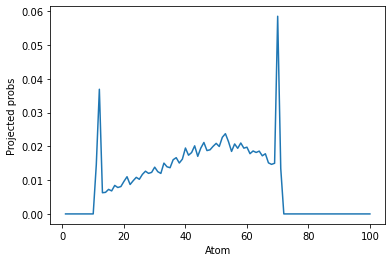

Episode 60: 	Actor Loss: -0.12 	Critic Loss: 2.14 
		Average Score: 28.91

SCORES (this eps):  [13.42531224 36.24979781 86.03776737 18.78264173 23.64404915 23.61146379
  7.57433449 11.31908154 12.86347092 13.04005232 10.86987098 72.5664596 ] 



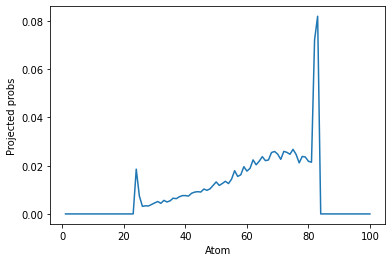

Episode 70: 	Actor Loss: -0.14 	Critic Loss: 1.95 
		Average Score: 26.65

SCORES (this eps):  [  5.31393428  33.18545845  65.53324876  56.33521536  31.9775603
  45.18496126 101.42946162  11.23451439  15.31005341  26.52502936
  23.86306608  30.737385  ] 



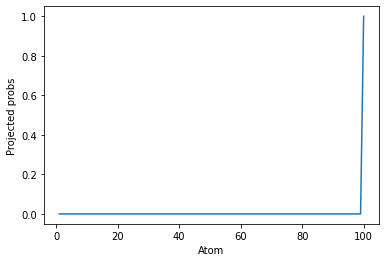

Episode 80: 	Actor Loss: -0.15 	Critic Loss: 1.74 
		Average Score: 34.00

SCORES (this eps):  [ 37.24978231  26.11767501 116.45561871   4.93236317  44.27876222
   2.87472055  41.05176396  32.26115711  47.50449739   7.35248195
   6.4841399   98.38253519] 



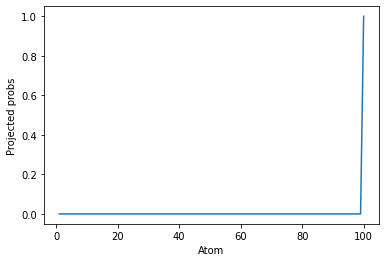

Episode 90: 	Actor Loss: -0.16 	Critic Loss: 1.63 
		Average Score: 44.30

SCORES (this eps):  [ 36.28193351  74.89657975  11.077598     9.22103438   9.18711866
  25.65889159 110.55164021  19.47090282  49.96730985  26.1302538
  34.51254679   3.45902302] 



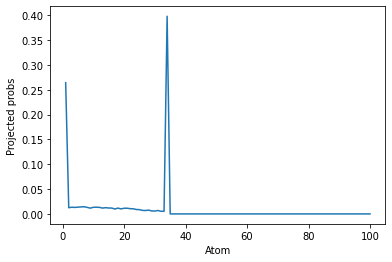

Episode 100: 	Actor Loss: -0.17 	Critic Loss: 1.51 
		Average Score: 57.38

SCORES (this eps):  [ 77.84602959 113.2864492  109.57239891  65.68526906  21.21620012
  97.06022948  47.44373874  79.0255822   35.40333732  98.02028865
  93.47089148 107.26975114] 



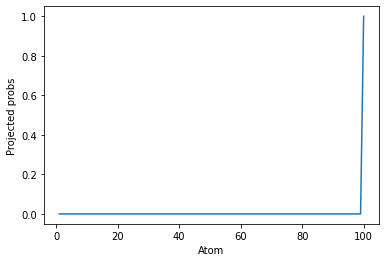

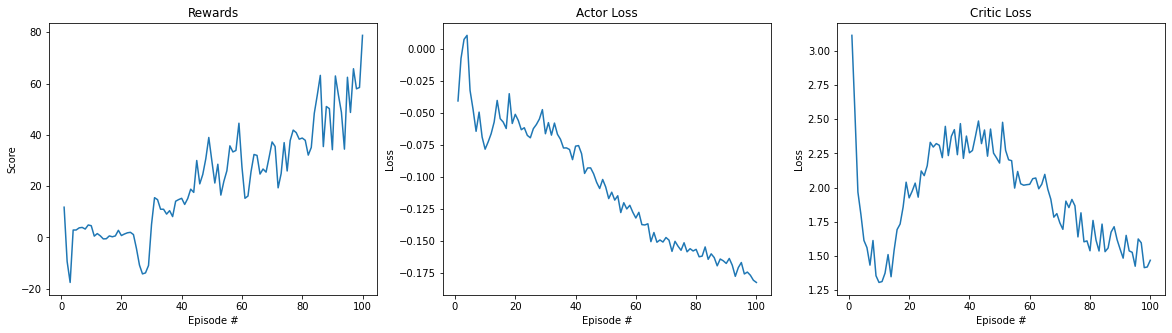

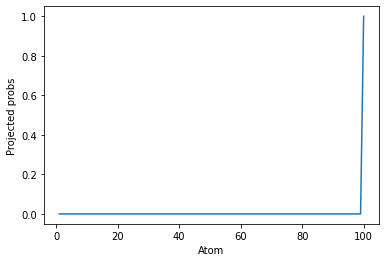

[11.78390031994301,
 -9.378222824200444,
 -17.55189378120849,
 2.8799226440799734,
 2.9007252799735093,
 3.73364605991325,
 3.899321770935785,
 3.26304053333782,
 4.850323584706833,
 4.571535169496201,
 0.5040270758715147,
 1.496981331690525,
 0.6199002344316492,
 -0.5793098320912881,
 -0.5096942709169525,
 0.5915628250416679,
 0.24804192168327668,
 0.5943071646033786,
 2.7731824793299893,
 0.7314057093656933,
 1.3267019994867344,
 1.7968418166662257,
 1.986324304365553,
 1.1137603431125171,
 -4.33596492294843,
 -10.78651954860834,
 -14.225168180603456,
 -13.826313622640251,
 -10.94906449819488,
 5.078462979702938,
 15.501428706911005,
 14.715310582997821,
 10.990373986559765,
 10.980760503327474,
 9.091840672733573,
 10.436121886023708,
 8.116963235428557,
 14.107299506911659,
 14.753455892505977,
 15.248611087474274,
 12.868463353486732,
 15.135249679364884,
 18.817768157590763,
 17.554489521193318,
 29.98714434336095,
 20.877032378552638,
 24.53637133635736,
 30.634754235157743,
 38

In [34]:
##################
# Vmax = -Vmin = 0.25
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.25'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.25'
params.num_atoms = 100
params.vmin = -0.25
params.vmax = 0.25


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.75
VMAX:  0.75
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.02 	Critic Loss: 3.40 
		Average Score: -1.62

SCORES (this eps):  [0.87494889 3.38793795 2.92216905 1.22829646 1.44069943 0.43259007
 1.25332318 2.79370089 0.11711715 1.8837858  1.86316748 2.44887953] 



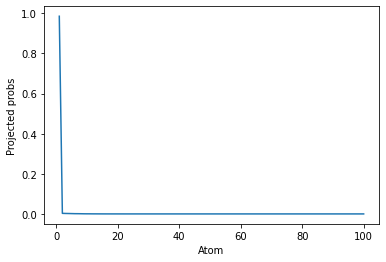

Episode 20: 	Actor Loss: -0.26 	Critic Loss: 3.05 
		Average Score: 2.98

SCORES (this eps):  [-9.88458005  0.38733949  3.9644308   0.80959877  3.60322048  0.13446978
 -1.6234351   1.96801613  2.89325059  0.93805375  0.          4.90863696] 



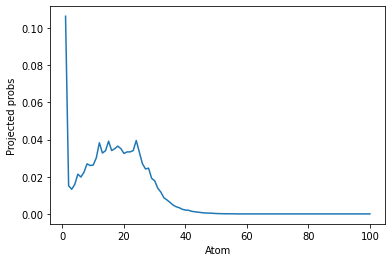

Episode 30: 	Actor Loss: -0.38 	Critic Loss: 2.55 
		Average Score: 6.71

SCORES (this eps):  [ 0.82214527  4.39810624  2.33979919  2.35005641  4.22927208  5.47908987
  9.92397518  8.48931353  5.55795204  5.11406411 11.32479369  2.42716236] 



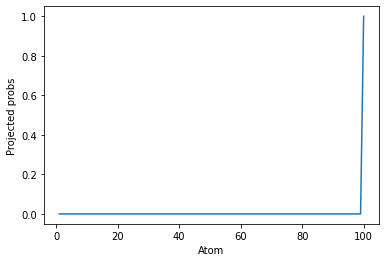

Episode 38\ Score: 16.22NaN Reward Found! Setting to 0...

NaN found in states. Skipping this episode.
Episode 39\ Score: 7.53
NaN found in actions. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, n

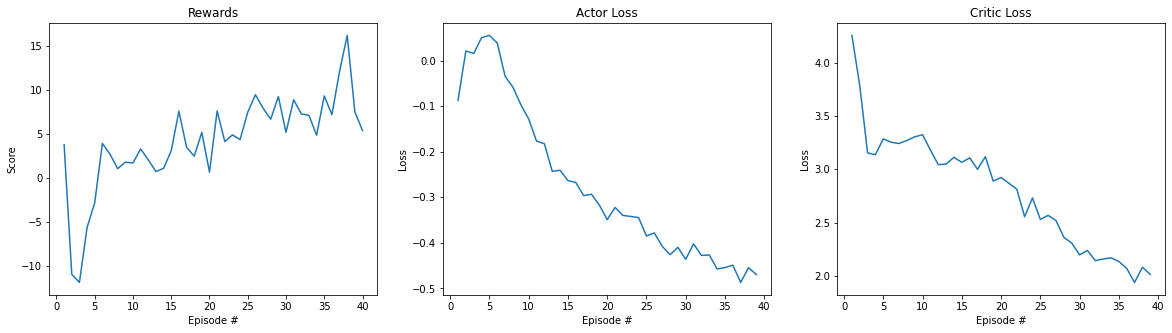

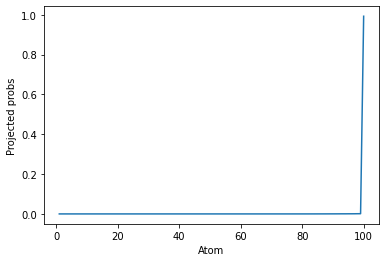

[3.7930394115513386,
 -10.935757037009656,
 -11.85889062502732,
 -5.626111121693005,
 -2.8161325418429137,
 3.943151611233285,
 2.7046986635929593,
 1.068924840927745,
 1.8025646027332793,
 1.7205513236888994,
 3.3077619290755442,
 2.076160409643004,
 0.7385919817412893,
 1.1070215974662763,
 3.113748132251203,
 7.600668211118318,
 3.516386763580764,
 2.4976017074659467,
 5.1905910614489885,
 0.674916798947379,
 7.627435868702984,
 4.1453680243964,
 4.909104377108936,
 4.374926639177526,
 7.48846758781777,
 9.470644367936378,
 7.943463497601139,
 6.693312989703069,
 9.256808896258008,
 5.20464416500181,
 8.908949932044683,
 7.296009023169366,
 7.126554792708096,
 4.875708007059681,
 9.338678959485454,
 7.213402021288251,
 12.127456162551729,
 16.218714376407053,
 7.527703233810219,
 5.395551540190354]

In [35]:
##################
# Vmax = -Vmin = 0.75
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.75'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.75'
params.num_atoms = 100
params.vmin = -0.75
params.vmax = 0.75


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

## Training for longer periods of time...


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -5
VMAX:  5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.51 	Critic Loss: 4.00 
		Average Score: 2.44

SCORES (this eps):  [15.59611149 12.18856682 32.59018762  5.28937671 10.5997339   1.92270081
 10.36359065  6.9449391   5.76241763  7.75497838  2.91403089  0.40987708] 



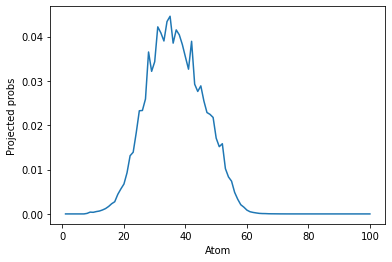

Episode 20: 	Actor Loss: -2.73 	Critic Loss: 2.68 
		Average Score: 15.68

SCORES (this eps):  [ 0.         14.02047596 22.81556343 29.9306918   2.61599693 17.9711262
 22.7542602  17.26743561  6.96782271 10.66493448  0.36426022 23.23019891] 



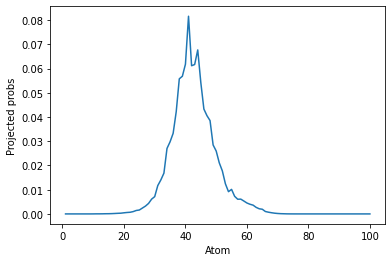

Episode 30: 	Actor Loss: -3.80 	Critic Loss: 1.84 
		Average Score: 23.13

SCORES (this eps):  [ 41.03034296  21.65866447  16.67000927  18.47901292   5.24280872
 103.50011973  44.32051727  25.96670653  35.22413429  59.21228316
  66.15114301  12.78407143] 



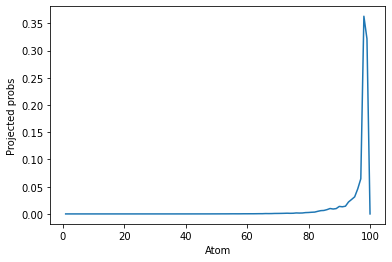

Episode 40: 	Actor Loss: -4.13 	Critic Loss: 1.53 
		Average Score: 28.15

SCORES (this eps):  [ 41.04405827  35.48780842  21.78192934  33.27801841  54.26071172
  57.48166643  52.38756733   9.93091452   0.40603117 123.32163786
  19.07400957  10.77234419] 



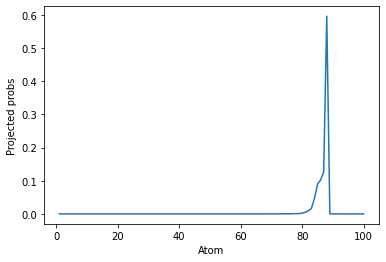

Episode 50: 	Actor Loss: -4.28 	Critic Loss: 1.33 
		Average Score: 31.21

SCORES (this eps):  [17.37682049 19.78120662 10.49845669 23.25857024 27.28147543 94.99519735
 22.92351382 18.51251117  8.49222757  0.93619053 69.79621928  7.99899061] 



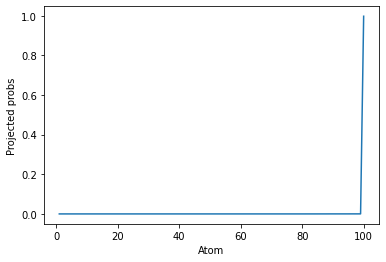

Episode 60: 	Actor Loss: -4.38 	Critic Loss: 1.17 
		Average Score: 33.66

SCORES (this eps):  [ 9.57031466  6.43290174 97.42926022 52.09040096 15.85715911  0.
  5.50051362  7.55650231 27.17730691 38.88101112 10.12968537 21.18821873] 



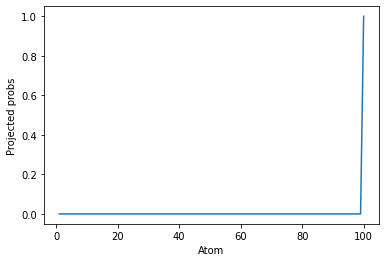

Episode 70: 	Actor Loss: -4.48 	Critic Loss: 1.07 
		Average Score: 37.46

SCORES (this eps):  [ 1.12643628e+01  3.46930753e-01 -2.32195333e-02  1.03534457e+02
  1.68111773e+00  2.30497992e+00  2.84982647e+01  2.07032265e+01
  4.11438392e+01  1.33793114e+01  5.25899834e+01  5.57032471e+01] 



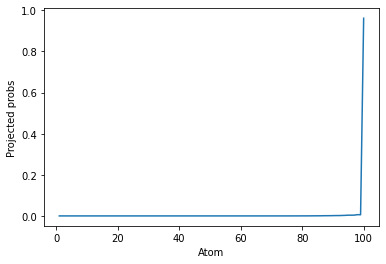

Episode 80: 	Actor Loss: -4.51 	Critic Loss: 1.00 
		Average Score: 37.96

SCORES (this eps):  [ 32.43689164  69.50477496  12.66401961   1.49778705  20.45110337
   1.51647043   6.82037287  51.24566081   1.71990648 141.83557671
  48.86803048  33.62791575] 



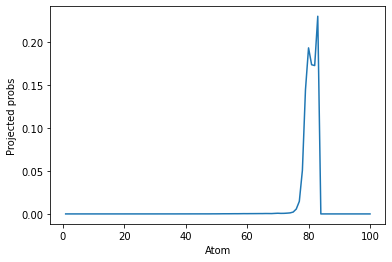

Episode 90: 	Actor Loss: -4.61 	Critic Loss: 0.88 
		Average Score: 47.05

SCORES (this eps):  [ 52.10544184  16.66022166  38.20024856  88.19305515   9.72880275
 114.12611323  30.21697079  36.93788252  74.37466929   1.89847217
   4.03918329  10.27770014] 



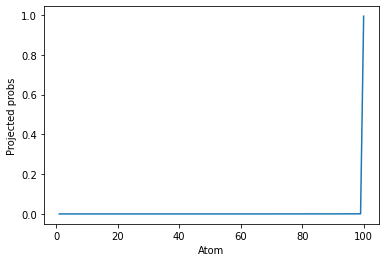

Episode 92\ Score: 42.63NaN Reward Found! Setting to -5.0...

NaN found in states. Skipping this episode.
Episode 93\ Score: 27.51
NaN found in actions. Skipping this episode.
Episode 94\ Score: 38.71
NaN found in states. Skipping this episode.
Episode 95\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 96\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 97\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 98\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 99\ Score: 0.00
NaN found in actions. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       

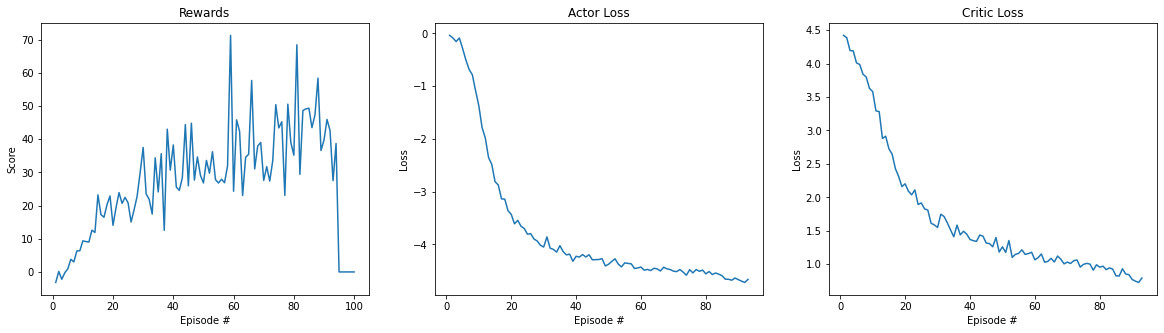

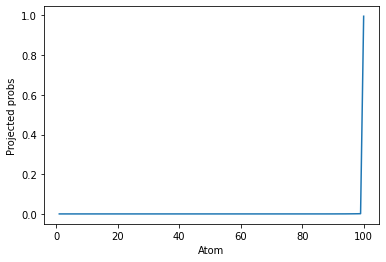

[-3.167317734051418,
 0.16388772505645952,
 -2.210069342079805,
 -0.26042430487965856,
 0.9390452129106658,
 3.808444249094464,
 3.0143600002241633,
 6.317313246817018,
 6.401771642655755,
 9.361375924510261,
 9.15605047593514,
 9.008552017815722,
 12.597433117606366,
 11.890849729534239,
 23.224929534907762,
 17.27214082763142,
 16.46422734026176,
 20.256379933833767,
 22.8970725062148,
 14.05023053707555,
 19.378636633511633,
 23.909638777802076,
 20.673410643435393,
 22.47425276991756,
 20.81256271728004,
 15.042708842006201,
 18.78079340257682,
 22.8108001324581,
 29.920217741241988,
 37.51998447960553,
 23.496417278579127,
 21.893943837028928,
 17.430817295098677,
 34.409519072039984,
 24.113723251425352,
 35.62637382070534,
 12.543859955156222,
 43.029293124641605,
 30.67682681129857,
 38.26889143651351,
 25.598169723448034,
 24.576343280263245,
 28.413155686110258,
 44.42579323666481,
 25.957782653315615,
 44.82631964496492,
 27.692681980707373,
 34.650703242785916,
 29.14957664

In [10]:
##################
# Vmax = -Vmin = 5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_5_longer'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_5_longer'
params.num_atoms = 100
params.vmin = -5
params.vmax = 5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.5
VMAX:  0.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.08 	Critic Loss: 3.27 
		Average Score: 7.21

SCORES (this eps):  [ -3.48394353 -19.87779433   1.7940252  -15.80512514 -15.34040895
  39.06676207  87.6680508   57.18090585 -25.08116238   0.31233507
   0.41529899   2.70780096] 



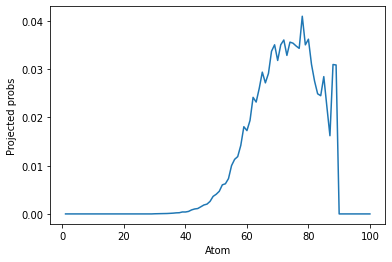

Episode 20: 	Actor Loss: -0.10 	Critic Loss: 3.26 
		Average Score: 2.45

SCORES (this eps):  [ -3.49798899  -8.55690674   4.11266258   4.8060932    2.0393074
  -9.7282432   -0.15070048 -10.6432631   -2.04432643  -9.97472336
   6.16256687 -18.34497729] 



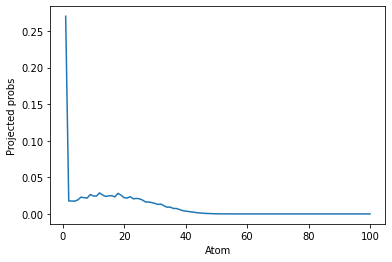

Episode 30: 	Actor Loss: -0.13 	Critic Loss: 3.20 
		Average Score: 10.45

SCORES (this eps):  [ 6.45323554  4.70770375  2.414364   16.30676805  5.12713869 13.02865802
  3.69726859 12.90557237 20.65260598  4.55970784  0.30276256 38.95801656] 



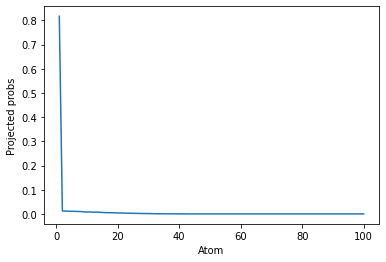

Episode 40: 	Actor Loss: -0.21 	Critic Loss: 2.85 
		Average Score: 9.60

SCORES (this eps):  [ 4.62976391 40.37523878  6.35072548 14.27846236  3.15776049  7.38158808
  8.07082698 10.52049946  6.35784263  3.70827106  3.14778104  0.17615863] 



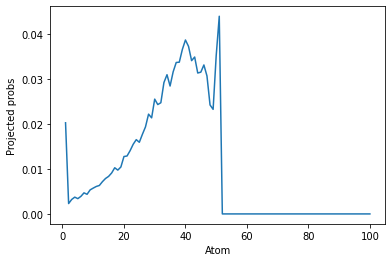

Episode 50: 	Actor Loss: -0.26 	Critic Loss: 2.60 
		Average Score: 10.91

SCORES (this eps):  [ 1.53146289 43.74338761 12.71837249 17.35071088  4.15746615  0.72396746
  6.78394602  5.50596352  2.59441425  4.12899301 17.09269726 30.50230336] 



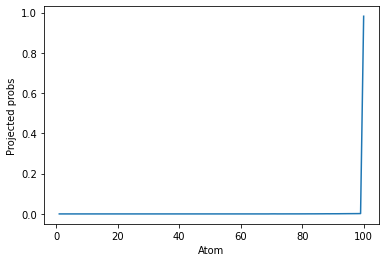

Episode 60: 	Actor Loss: -0.28 	Critic Loss: 2.32 
		Average Score: 10.92

SCORES (this eps):  [45.97339718 13.03351714  4.3139362   3.09269554 16.7495758  23.62348398
 15.10267819  6.37359986 26.15870892  6.80334357  6.11691633 17.25049578] 



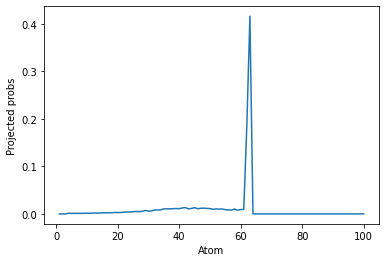

Episode 70: 	Actor Loss: -0.31 	Critic Loss: 2.11 
		Average Score: 11.69

SCORES (this eps):  [ 8.53961374  9.76921666 20.57199625 15.29314678  8.00042779 14.46832661
 10.9571419   5.56429402 37.3956532   7.27220761 14.74846128 28.85410624] 



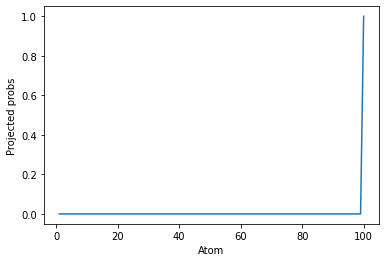

Episode 80: 	Actor Loss: -0.33 	Critic Loss: 1.87 
		Average Score: 14.79

SCORES (this eps):  [31.63404431 20.71262117 11.39819497 10.82093759 27.8540293  46.09816082
  2.25064353  0.16967498 16.29837876 32.23290619 18.62802807  9.23348456] 



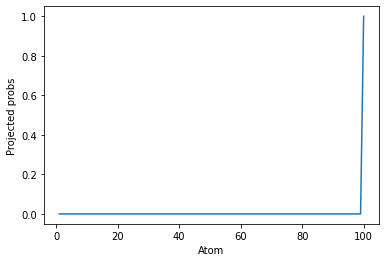

Episode 90: 	Actor Loss: -0.35 	Critic Loss: 1.75 
		Average Score: 10.70

SCORES (this eps):  [ 7.94214362 17.9814706   0.61546823 11.84973833 14.8333348  13.99391051
 15.27614992 18.68187952 12.18344573 11.55092987 19.93060386 27.5033874 ] 



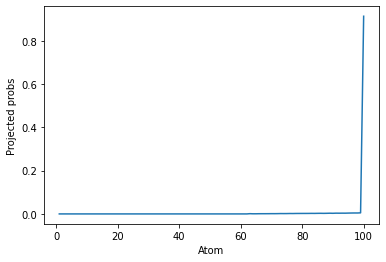

Episode 100: 	Actor Loss: -0.38 	Critic Loss: 1.42 
		Average Score: 15.34

SCORES (this eps):  [ 1.75641626 37.78800835 25.2111018  20.02899054 12.41899616 29.84614785
 96.4269407  29.00639506 13.88390903  8.43421294 46.15036292 19.70526   ] 



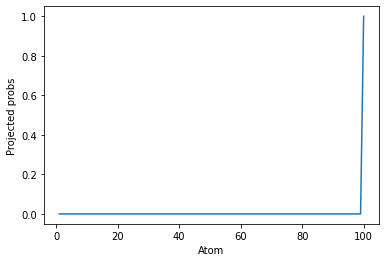

Episode 110: 	Actor Loss: -0.40 	Critic Loss: 1.06 
		Average Score: 21.73

SCORES (this eps):  [ 0.31636296 73.52721169  5.37077008 21.63368253 34.24662153  2.66583904
  4.7377348  25.07791054 15.60219922  8.20423482 19.63761583  1.69414343] 



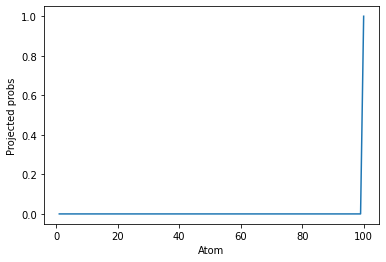

Episode 120: 	Actor Loss: -0.42 	Critic Loss: 0.87 
		Average Score: 23.77

SCORES (this eps):  [26.28883395  2.70912702 56.82959252 16.84977129 23.43012253  7.92479606
 23.36720756 51.13277285 17.32448426  5.5104001  12.70287269 15.39716752] 



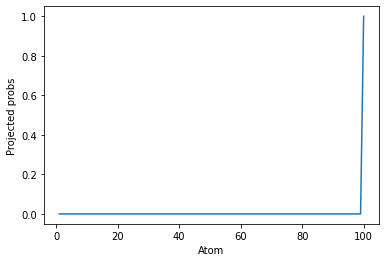

Episode 130: 	Actor Loss: -0.43 	Critic Loss: 0.68 
		Average Score: 37.68

SCORES (this eps):  [ 40.37171062   2.16783297  89.01286932   4.66851422  81.11468692
 102.46917551   8.57541      3.3002219    2.3376436   38.28601758
  33.1660007   22.19665763] 



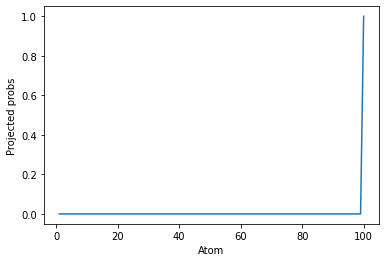

Episode 140: 	Actor Loss: -0.45 	Critic Loss: 0.58 
		Average Score: 55.15

SCORES (this eps):  [ 36.21019755   9.8521631    1.57743781 168.73653377 203.06241209
  85.31051438  20.81701185  80.03869629  26.82774071  29.32553696
   7.69588038  42.25179227] 



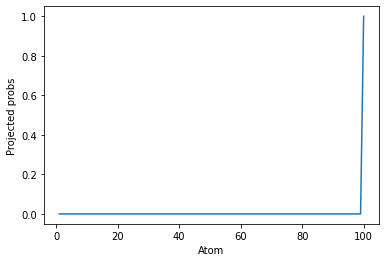

Episode 150: 	Actor Loss: -0.46 	Critic Loss: 0.46 
		Average Score: 63.69

SCORES (this eps):  [ 36.23542127  16.51856947   3.05844437  36.08112206   1.27060422
  58.00122     69.93517232  31.08550641 135.65916867  45.56173324
  12.2695584   18.2611841 ] 



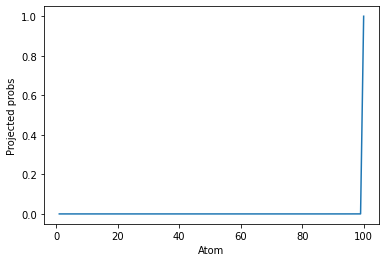

Episode 160: 	Actor Loss: -0.46 	Critic Loss: 0.42 
		Average Score: 64.77

SCORES (this eps):  [  7.22468107  30.90114417  25.61543429 117.81404791   9.14679847
  36.65584336  11.30789944  96.65011858  38.19182843  58.02563795
  89.12079969  45.8229497 ] 



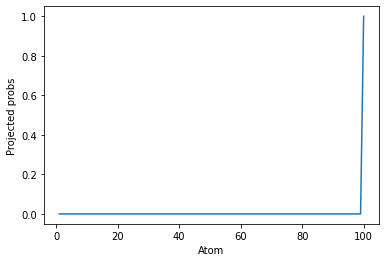

Episode 170: 	Actor Loss: -0.47 	Critic Loss: 0.34 
		Average Score: 55.80

SCORES (this eps):  [ 73.39105388  24.94467806   6.13173331  90.63271931  47.01187171
  29.58755914 168.15877151 176.49021399 107.25526351  34.56157576
  79.39595427  40.53431933] 



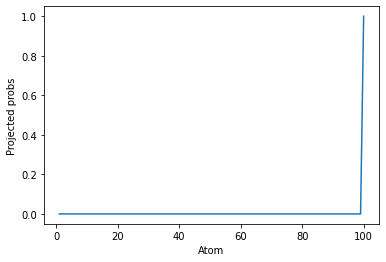

Episode 180: 	Actor Loss: -0.48 	Critic Loss: 0.32 
		Average Score: 65.87

SCORES (this eps):  [51.81739089 33.21370626 57.68183768 10.33492981 86.98748145 42.73891993
 10.49054171  9.96734778 76.23664286 36.01891551 46.26105169 56.17076485] 



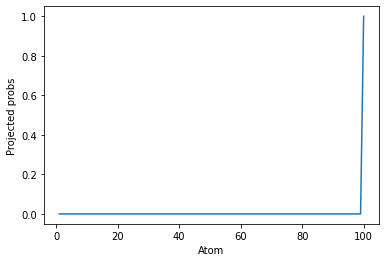

Episode 190: 	Actor Loss: -0.48 	Critic Loss: 0.31 
		Average Score: 83.60

SCORES (this eps):  [ 32.65261603  19.82274833  19.9629011   93.21750554  83.28892815
  47.26357366  12.40585977 108.93288369  14.88589497 107.1788845
  66.82762402 145.11424543] 



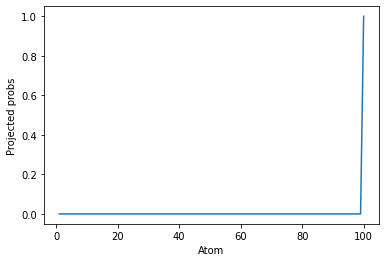

Episode 200: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 71.64

SCORES (this eps):  [134.37782541  24.38417636 175.20734952  22.20284784  14.14531769
  10.49168018  88.18131686  15.94862012   5.45869103 155.89257601
 118.47802194  88.03293956] 



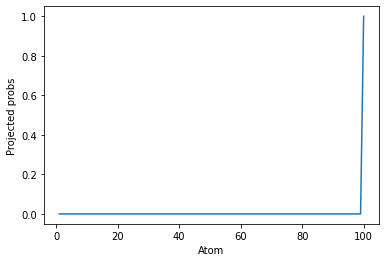

Episode 210: 	Actor Loss: -0.48 	Critic Loss: 0.28 
		Average Score: 68.81

SCORES (this eps):  [129.76673233  85.61244496  43.76155634   0.         132.26630961
   0.53801237  94.42148621  96.13719668   0.14182854  62.72871563
  32.88964036  42.08243957] 



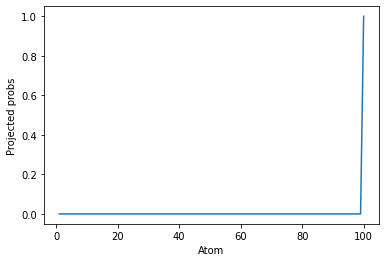

Episode 220: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 84.87

SCORES (this eps):  [ 78.44615095 135.47210121   4.35384543  87.66798307  72.93858727
  47.95579079 134.12842373  45.87557911 166.32532537  99.16366609
  10.54910242  47.23264478] 



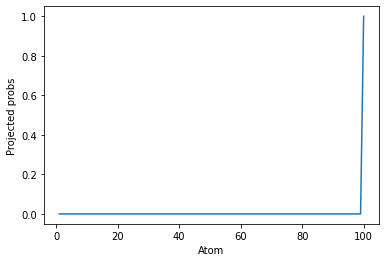

Episode 230: 	Actor Loss: -0.48 	Critic Loss: 0.30 
		Average Score: 73.19

SCORES (this eps):  [  8.74320032  68.67913863  23.12914974  21.61344317 176.51910012
  23.20307027  35.72677627  30.76566023  72.37394877  77.32015934
  36.99165408   4.08324207] 



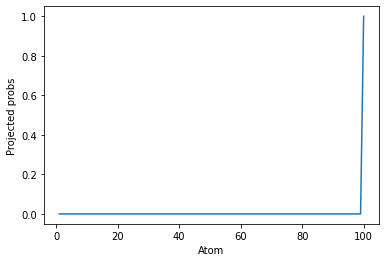

Episode 240: 	Actor Loss: -0.48 	Critic Loss: 0.31 
		Average Score: 103.54

SCORES (this eps):  [ 79.84442562 131.99486464 109.20588674 175.88333085  72.75763513
 158.76378779  54.02524808 152.05969335 150.75621753  27.3302083
 112.91979117 116.44665794] 



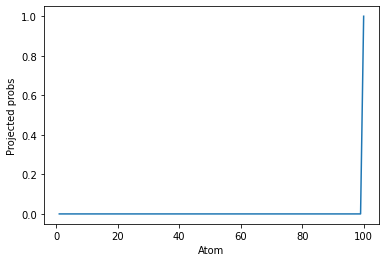

Episode 250: 	Actor Loss: -0.48 	Critic Loss: 0.32 
		Average Score: 89.24

SCORES (this eps):  [147.86050072  71.61784858  61.36039512  88.70627312 169.3130773
  14.9931093  158.0703741  169.62215263 172.5466701  122.1788478
 148.82572913  29.63899437] 



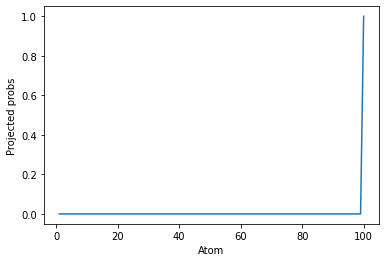

Episode 260: 	Actor Loss: -0.48 	Critic Loss: 0.29 
		Average Score: 82.78

SCORES (this eps):  [152.90041703  33.48950279 156.19061187 129.72666875  21.27158007
 122.35112341 196.44190577 150.1350908   55.37200818 128.16349561
  26.1674432   32.61206575] 



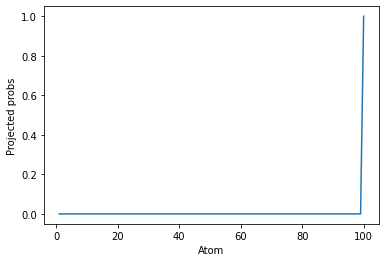

Episode 270: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 86.39

SCORES (this eps):  [150.05121433 167.24328053 156.09694752  16.30205935 170.96188585
 137.15509501 156.71288684  26.77722057 151.02427767  13.0001607
 163.57695083 181.0973041 ] 



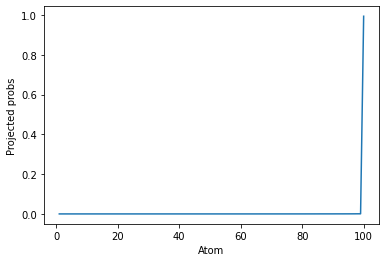

Episode 280: 	Actor Loss: -0.49 	Critic Loss: 0.24 
		Average Score: 122.01

SCORES (this eps):  [163.56832568 168.97016147  12.64904448 180.85556995 164.21288174
 118.46878285 161.20407698 151.33362283 167.58095952 111.17451851
 169.59861099  58.61031277] 



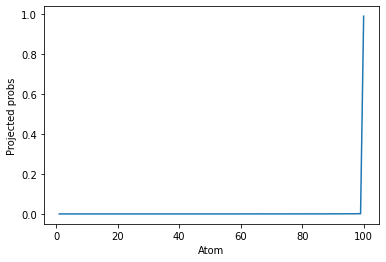

Episode 290: 	Actor Loss: -0.49 	Critic Loss: 0.23 
		Average Score: 120.38

SCORES (this eps):  [149.73460494 154.73568737  61.79924485  90.24667322  26.14267835
 163.90454705   3.98402206 127.26604417  23.48681999 141.00851855
 163.87111121 165.75697838] 



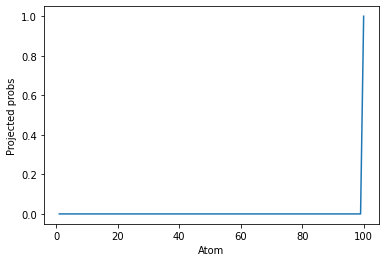

Episode 300: 	Actor Loss: -0.49 	Critic Loss: 0.22 
		Average Score: 109.14

SCORES (this eps):  [164.08342004 176.12077947  95.37996747  78.47539338  35.30338161
  92.56756612 160.67192323 164.58656977 153.58703759 153.41872878
  58.04457858 162.28854543] 



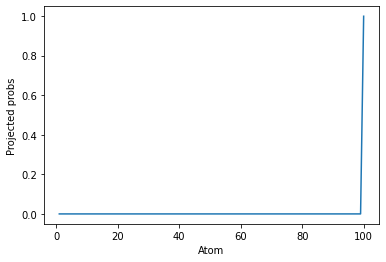

Episode 310: 	Actor Loss: -0.49 	Critic Loss: 0.20 
		Average Score: 93.35

SCORES (this eps):  [168.66037997 175.05297335  52.11508087  19.45923189 174.23867452
  17.6459559  104.03500358  85.74056596  33.28304047  61.07348007
  99.97712441  97.53930151] 



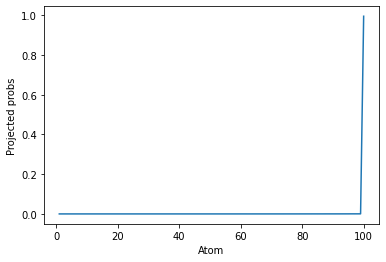

Episode 320: 	Actor Loss: -0.49 	Critic Loss: 0.18 
		Average Score: 90.51

SCORES (this eps):  [149.46278711   9.21491133  80.2417546   10.61997054 135.67479806
   9.4791004   77.61492872  25.66427493  43.44307768  27.57323548
  71.51225213  83.65412033] 



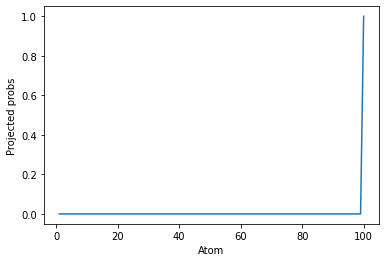

Episode 330: 	Actor Loss: -0.49 	Critic Loss: 0.18 
		Average Score: 87.29

SCORES (this eps):  [ 42.66763852 100.8248827  150.70488788 110.65302339 157.28900842
  49.18580997   6.37278819 164.78130937  18.15454924  36.53240092
  38.33455706  83.87597044] 



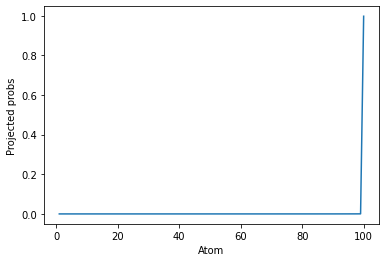

Episode 340: 	Actor Loss: -0.49 	Critic Loss: 0.18 
		Average Score: 57.53

SCORES (this eps):  [ 38.39333868 170.22635795   3.41540099  51.69600782  17.68087066
  67.82386407  42.10442793   0.77367102 113.90862614  33.30508817
   3.7078326  158.09766431] 



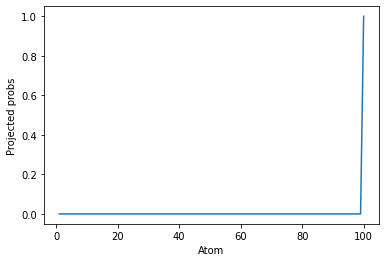

Episode 350: 	Actor Loss: -0.49 	Critic Loss: 0.19 
		Average Score: 87.52

SCORES (this eps):  [ 26.70807073  14.25526615  87.08981876  61.77531518 164.03398812
 145.33217683 106.35530223 138.27459879  99.73585267   9.41872812
 123.65594158 125.90037971] 



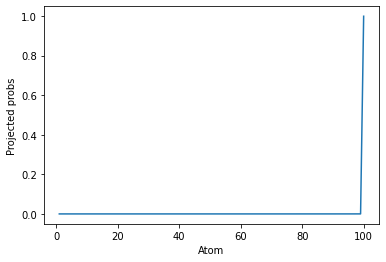

Episode 360: 	Actor Loss: -0.49 	Critic Loss: 0.23 
		Average Score: 77.49

SCORES (this eps):  [ 55.42563682 110.89005664  42.99545926  18.38659997 115.83125618
  16.06275099  11.71173172 161.52001616  41.03177131 126.83658334
   8.36535692  57.77265249] 



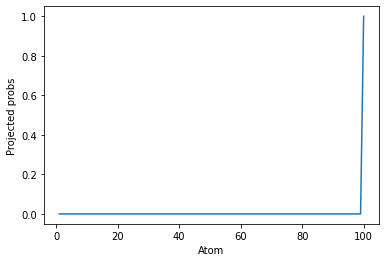

Episode 370: 	Actor Loss: -0.48 	Critic Loss: 0.24 
		Average Score: 96.88

SCORES (this eps):  [139.83015534  31.89646161  40.0774725   43.41001658  11.51091563
  99.74992733 155.59765628 151.16815966  16.72143281 150.72231802
  56.64261672  22.77909522] 



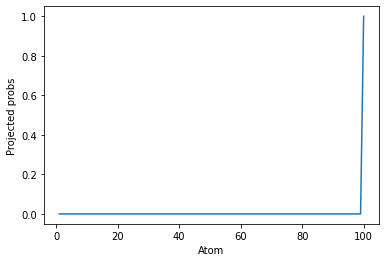

Episode 380: 	Actor Loss: -0.48 	Critic Loss: 0.23 
		Average Score: 69.52

SCORES (this eps):  [ 22.44691638 151.69090399  20.88099706  53.8073021   49.81538957
   5.09992159   5.0560903   41.12765815  32.80474667 153.78772892
 170.70292643  31.23969487] 



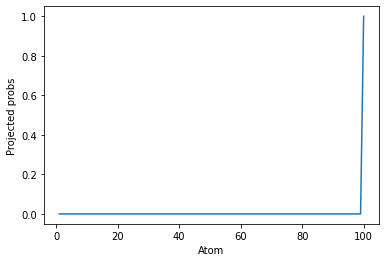

Episode 390: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 75.45

SCORES (this eps):  [ 60.29489584  75.14581278  14.33638655 111.09162055  27.38465834
  62.34919699  54.62248406 160.90777302  24.93785509 131.27016096
  80.91406638  72.11722549] 



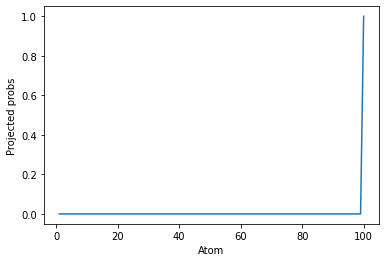

Episode 400: 	Actor Loss: -0.48 	Critic Loss: 0.30 
		Average Score: 65.24

SCORES (this eps):  [26.19770241 42.42894167 62.96053446 23.76446187 47.70727557 26.58903412
 31.01698548 39.90690923  5.83791481 76.30604169 99.77678125 23.09334911] 



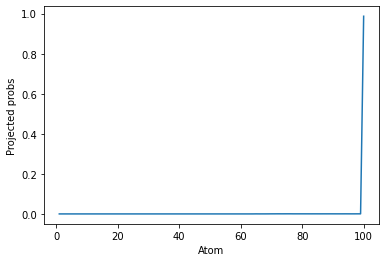

Episode 410: 	Actor Loss: -0.48 	Critic Loss: 0.29 
		Average Score: 87.74

SCORES (this eps):  [157.93911155  28.4292174  161.13345687  22.40597346 184.124127
 133.78753162 163.96829222  86.39296912  23.55593127 154.20758583
  25.62331085 172.37464762] 



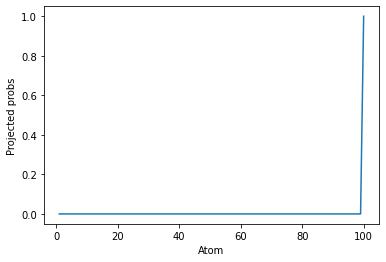

Episode 420: 	Actor Loss: -0.47 	Critic Loss: 0.31 
		Average Score: 93.26

SCORES (this eps):  [165.2452449   49.58589872 163.51188881  87.76045054  62.59574586
  75.87122393 164.6884866  161.30806405 110.31751793 146.91554424
 105.18741696  40.38166826] 



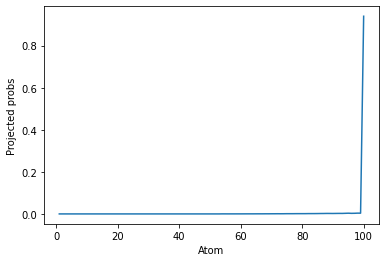

Episode 430: 	Actor Loss: -0.48 	Critic Loss: 0.29 
		Average Score: 105.16

SCORES (this eps):  [154.65246416  91.25952552  28.07411471 173.67342939 157.98993861
 161.72808212 160.32567151 166.73590987  23.23177116 158.54006784
 167.21163254   5.26288273] 



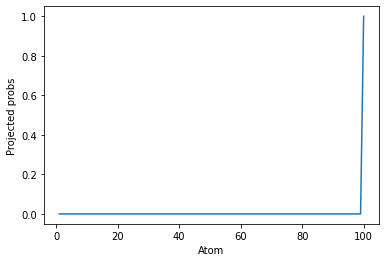

Episode 440: 	Actor Loss: -0.48 	Critic Loss: 0.29 
		Average Score: 97.35

SCORES (this eps):  [ 17.18724632  30.70370101 162.29420659 137.35986489 153.64531582
 132.22558453 143.41212955 100.12726905   3.2061107  125.3225304
 163.80577113  38.61474782] 



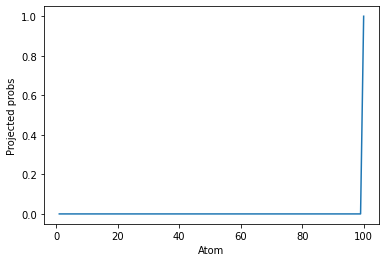

Episode 444\ Score: 62.185

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([1.3394e-14, 6.3572e-12, 4.8541e-02, 2.3332e-01, 1.8078e-01, 1.5905e-01,
        1.5148e-01, 2.1463e-01, 1.9068e-01, 1.1236e-01, 1.4665e-15, 8.0809e-02,
        6.1363e-02, 2.2936e-02, 4.1477e-02, 4.6219e-02, 6.5838e-02, 1.4665e-15,
        1.0834e-01, 7.7225e-02, 3.8626e-02, 3.4286e-02, 3.4753e-02, 5.5307e-02,
        4.7908e-02, 7.5290e-02, 3.8525e-02, 4.6691e-02, 2.5371e-02, 1.4665e-15,
        3.9355e-02, 5.3516e-02, 7.0310e-02, 7.0610e-02, 4.4014e-02, 3.8977e-02,
        3.9870e-02, 5.2165e-02, 7.9669e-02, 9.9382e-02, 7.9022e-02, 4.7932e-02,
        1.4665e-15, 1.4665e-15, 4.0131e-02, 1.4665e-15, 9.6430e-02, 9.1350e-02,
        5.4758e-02, 4.0161e-02, 4.4567e-02, 3.6568e-02, 6.3861e-02, 4.7865e-02,
        4.5181e-02, 4.0860e-02, 4.4975e-02, 1.4665e-15, 3.7554e-02, 5.3464e-02,
        7.6425e-02, 6.7936e-02, 4.0194e-02, 4.2096e-02, 4.2125e-02, 6.7597

Actor/bn2.bias Parameter containing:
tensor([0.1092, 0.0445, 0.0304, 0.0832, 0.0602, 0.1230, 0.1367, 0.1944, 0.2110,
        0.1637, 0.0480, 0.0706, 0.0112, 0.1128, 0.1008, 0.1482, 0.0316, 0.2275,
        0.0425, 0.0365, 0.1123, 0.1658, 0.0754, 0.1850, 0.0975, 0.0593, 0.0157,
        0.1483, 0.0244, 0.1238, 0.0427, 0.1793, 0.0441, 0.1782, 0.0545, 0.1489,
        0.0752, 0.1404, 0.0918, 0.0212, 0.1498, 0.0563, 0.0186, 0.1087, 0.1551,
        0.0430, 0.0277, 0.1165, 0.1620, 0.0855, 0.0219, 0.0314, 0.1593, 0.0933,
        0.2002, 0.1173, 0.2182, 0.2378, 0.0537, 0.1053, 0.1630, 0.0352, 0.1299,
        0.0437, 0.1210, 0.1190, 0.0209, 0.0856, 0.1208, 0.0233, 0.1146, 0.1360,
        0.1459, 0.1533, 0.0240, 0.1144, 0.1330, 0.0818, 0.1903, 0.0353, 0.0799,
        0.0528, 0.1427, 0.2533, 0.1222, 0.1896, 0.0488, 0.0672, 0.1177, 0.1240,
        0.0904, 0.0616, 0.1647, 0.1812, 0.1128, 0.0273, 0.1855, 0.1752, 0.0779,
        0.0895, 0.0301, 0.1558, 0.0805, 0.1553, 0.0154, 0.0173, 0.1822, 0.0813,
   

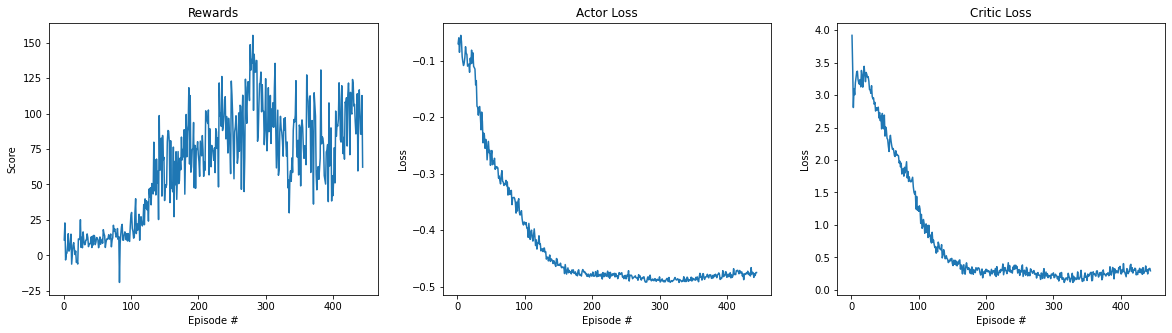

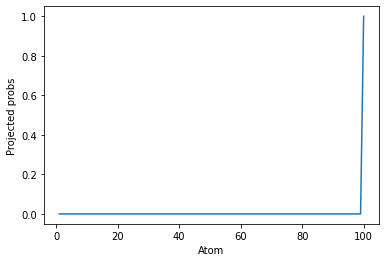

[10.894480807110085,
 22.895678641827544,
 -3.184835626355683,
 0.9681179172669848,
 1.677589703234844,
 7.149371302401657,
 15.323074869794558,
 3.0147943314920362,
 4.21360373646409,
 9.129728716516789,
 14.990681331206966,
 -6.144995602274624,
 -0.028738261433318257,
 7.0421644305606605,
 9.01880077328436,
 4.654277023718653,
 0.658679126935264,
 3.0709100272894525,
 -4.929805992876936,
 -3.8183749626526455,
 -6.080045191351625,
 11.631385336229869,
 11.512972519084238,
 11.166842700700121,
 25.16443404116823,
 5.650748179371779,
 12.793438228487503,
 5.3698989995755255,
 16.57362037144291,
 10.759483495222716,
 7.613856383541133,
 7.6650608967950875,
 10.722933760494925,
 10.913417533777343,
 15.16386744985357,
 12.506572408000162,
 6.175228406277408,
 8.327976326923817,
 7.9342056105379015,
 9.012909907770032,
 13.04226305213524,
 5.548097630977281,
 13.604702825856899,
 7.3227486610218575,
 14.147961626207689,
 13.662518710945733,
 7.61462602832277,
 9.313589319819584,
 12.595198

In [27]:
##################
# Vmax = -Vmin = 0.5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.5_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.5_longest'
params.num_atoms = 100
params.vmin = -0.5
params.vmax = 0.5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

## Resuming Training to see how far it goes...


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.5
VMAX:  0.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 110: 	Actor Loss: -0.45 	Critic Loss: 0.86 
		Average Score: 47.62

SCORES (this eps):  [  5.90077691 140.70757813  60.89671407 161.83428994   4.56916877
   1.33504715   6.47866377 176.79238049   8.47062654  33.03638487
   4.40183288  39.03048738] 



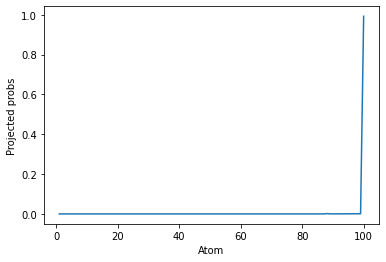

Episode 120: 	Actor Loss: -0.47 	Critic Loss: 0.46 
		Average Score: 54.07

SCORES (this eps):  [ 18.87852341  33.93129474  69.34345039  82.82878725  80.56153248
  40.27978563  38.27727152 143.22867688 126.74404898 178.98902902
 150.80882613  22.30586369] 



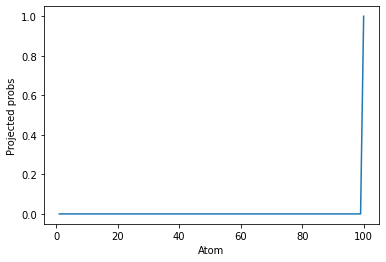

Episode 130: 	Actor Loss: -0.47 	Critic Loss: 0.36 
		Average Score: 61.27

SCORES (this eps):  [169.1167412   28.61660431  76.06040152   9.73994167 127.19028523
  48.70869418 106.54653308   5.99867525  63.10850669  12.15519351
   7.96858325   7.94443865] 



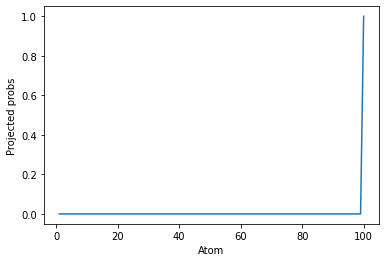

Episode 140: 	Actor Loss: -0.47 	Critic Loss: 0.31 
		Average Score: 87.89

SCORES (this eps):  [ 34.45104993 121.27610699 133.7743747   65.62670719  38.38435401
  46.67082548  41.74338133  23.74299976  89.08693045  50.18539704
 173.1081482   95.13100845] 



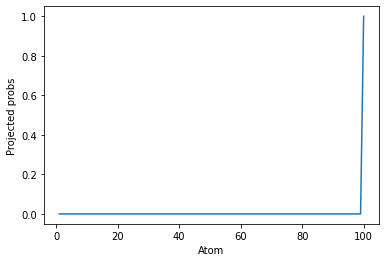

Episode 150: 	Actor Loss: -0.48 	Critic Loss: 0.31 
		Average Score: 82.68

SCORES (this eps):  [155.96517244   1.13954787   1.95932284 180.81472676 175.43829882
  11.9419018  101.60940387  61.12485385  13.39723767 180.20193094
  54.27055328 109.54807556] 



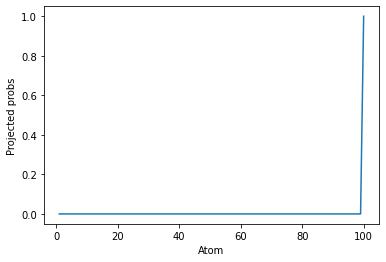

Episode 160: 	Actor Loss: -0.47 	Critic Loss: 0.30 
		Average Score: 101.86

SCORES (this eps):  [180.47916819 185.09464744  26.53858115 111.52873994 200.82051959
 168.56124625  10.54668619  60.46822336  64.42449499 114.01841091
  52.38905277 152.2190986 ] 



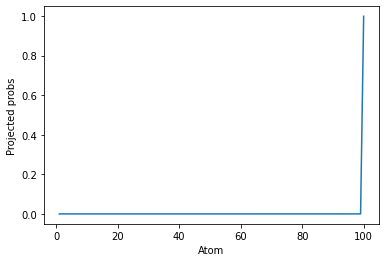

Episode 170: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 86.99

SCORES (this eps):  [ 16.78280648  99.89438636 192.59775856  98.83928826 165.12087281
 131.25696306   4.94366745  15.24601402 134.08257896  68.55631801
 134.87980373 149.09806472] 



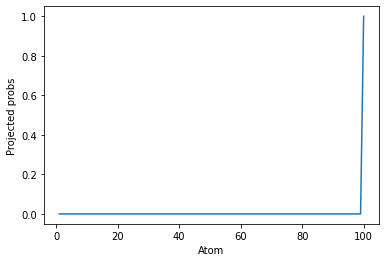

Episode 180: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 84.08

SCORES (this eps):  [139.66399244 139.6921164   61.19506234 124.03565291  21.37120456
  39.97264714 146.81479344 117.65414733  96.3635477   80.11269977
  53.51359812  34.42426608] 



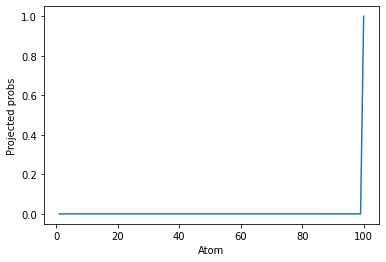

Episode 190: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 102.93

SCORES (this eps):  [  9.83311821 178.44782184  85.59252534  66.32056066  91.35506354
 175.85608276  58.26103059  50.88509681  79.16618649  21.28551543
  55.32338544 142.19126558] 



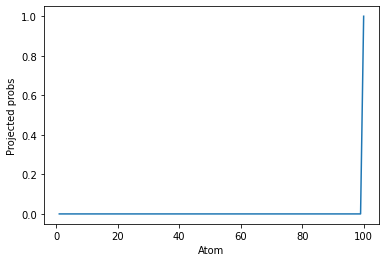

Episode 200: 	Actor Loss: -0.48 	Critic Loss: 0.24 
		Average Score: 94.52

SCORES (this eps):  [150.57441064 169.38935148  86.03974432 132.42358667 127.4823455
  29.39046853  15.59240784  57.3212465   49.3472292  153.10185847
  75.25665091 165.10875407] 



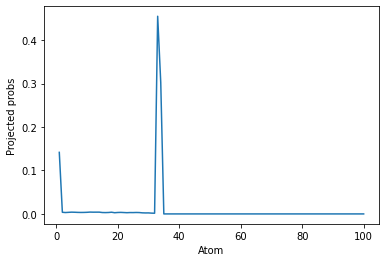

Episode 210: 	Actor Loss: -0.48 	Critic Loss: 0.25 
		Average Score: 77.16

SCORES (this eps):  [132.28322624 105.532945    33.73645934  23.08382655  95.41501233
  41.48089213  92.93533703  38.81468336 120.91548086  23.03889457
 151.88523967 154.58460029] 



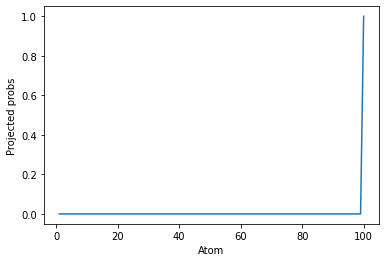

Episode 220: 	Actor Loss: -0.48 	Critic Loss: 0.20 
		Average Score: 66.17

SCORES (this eps):  [ 67.49222592  55.9166164    7.4934891   47.86408116  26.10892171
  49.73740044 141.48025686   3.24735384 143.51171924   4.84988582
 147.35286172 150.19437012] 



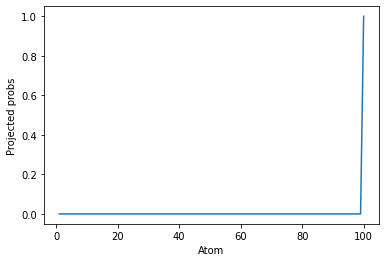

Episode 230: 	Actor Loss: -0.49 	Critic Loss: 0.21 
		Average Score: 83.09

SCORES (this eps):  [154.48964679  12.7354797  178.70388183  43.98323773  40.32708675
  26.09934856  15.89359045  61.5293451   27.25907112  53.59298564
  12.91462703 166.32292614] 



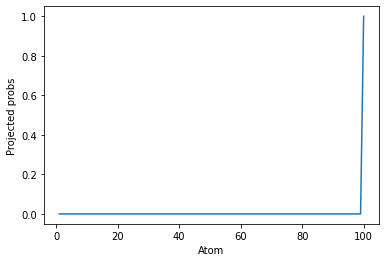

Episode 240: 	Actor Loss: -0.48 	Critic Loss: 0.24 
		Average Score: 91.31

SCORES (this eps):  [ 94.41541984  64.56360462 116.54400885 114.63362495  86.16972712
   8.3361108   59.49120622 103.5504358  150.96589406  53.41170204
  35.91897074  47.13001469] 



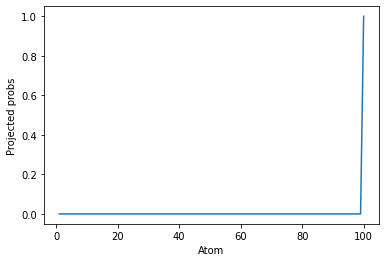

Episode 250: 	Actor Loss: -0.48 	Critic Loss: 0.23 
		Average Score: 85.65

SCORES (this eps):  [135.79723043 189.02067286  29.50328017 177.06165902  59.10052259
 135.33933568   9.40000371  40.93874141 126.35106882  13.90660259
  35.69666455  32.10071167] 



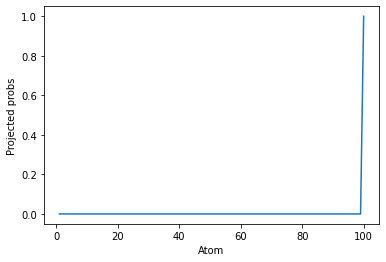

Episode 260: 	Actor Loss: -0.48 	Critic Loss: 0.24 
		Average Score: 75.42

SCORES (this eps):  [ 27.9149785  115.40445854 150.8803315   33.09779383  45.57835836
  16.48065105  65.07822692  44.88144123   3.75207977   4.32168353
 152.70721184  95.65665701] 



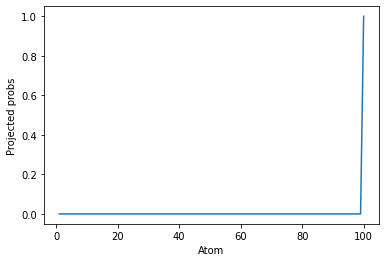

Episode 270: 	Actor Loss: -0.48 	Critic Loss: 0.28 
		Average Score: 69.00

SCORES (this eps):  [4.92761035e+01 1.51447903e+02 1.70232497e+01 1.78696282e+00
 1.50883576e+02 6.87229335e-02 7.91356716e+01 1.37184159e+01
 6.91238909e+01 3.13664215e+01 5.74451298e+01 9.50124270e+01] 



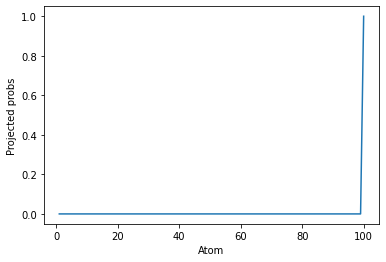

Episode 280: 	Actor Loss: -0.48 	Critic Loss: 0.26 
		Average Score: 66.18

SCORES (this eps):  [137.46468067  28.25969966  38.70649098 179.06207269  12.92466863
 158.19368331  19.38262167  35.62429395   0.82667177 186.17465831
  32.20950072  20.92116426] 



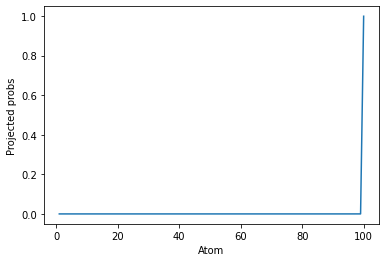

Episode 290: 	Actor Loss: -0.48 	Critic Loss: 0.26 
		Average Score: 73.52

SCORES (this eps):  [115.01296714  28.05317721  30.5236087    3.29843153  28.73971429
  78.64889901 170.9872513  177.05832563  26.78425711 178.2077001
 154.43518738 150.17453331] 



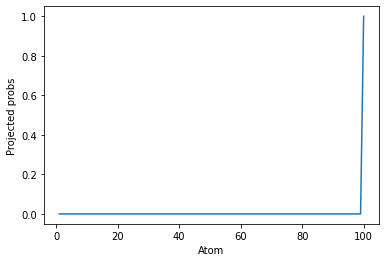

Episode 300: 	Actor Loss: -0.47 	Critic Loss: 0.28 
		Average Score: 71.34

SCORES (this eps):  [ 75.92240547   9.02036673   2.33759372 181.82498771 114.52297644
 137.13996513   9.72129775  50.75270359 176.74913745   3.54658129
 151.60004335  20.82709361] 



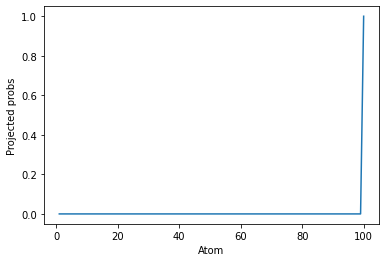

Episode 310: 	Actor Loss: -0.47 	Critic Loss: 0.31 
		Average Score: 53.03

SCORES (this eps):  [131.14625598  13.16595122  16.84698103  46.05535094  31.89693719
 108.04721246  52.95215517  83.37678084  22.14915978 116.52930226
  42.61219196 175.85071858] 



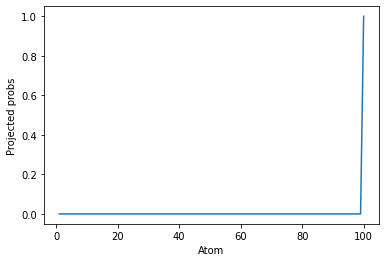

Episode 320: 	Actor Loss: -0.47 	Critic Loss: 0.33 
		Average Score: 73.62

SCORES (this eps):  [104.7771763    9.98973919  61.48526859  87.84905505  97.59051324
 213.4416486  169.11589175 102.22169096 146.07488769 176.11936778
 211.86467134  18.94770915] 



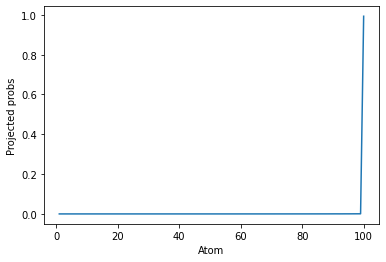

Episode 330: 	Actor Loss: -0.47 	Critic Loss: 0.33 
		Average Score: 59.79

SCORES (this eps):  [104.84541095  79.33536889 123.08944511  21.9191628    3.16441517
  39.55214713   5.75073921  69.80984309  10.37069903  63.23081004
  68.52483145  17.93369663] 



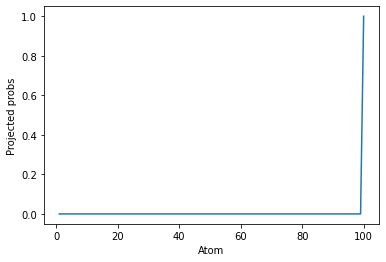

Episode 340: 	Actor Loss: -0.47 	Critic Loss: 0.35 
		Average Score: 62.16

SCORES (this eps):  [ 16.01994568  40.62914308  37.06018426 135.31781147 128.60031373
  82.58096778  27.99571585  67.09224918  26.75261357  30.472013
  77.44895322  42.30947655] 



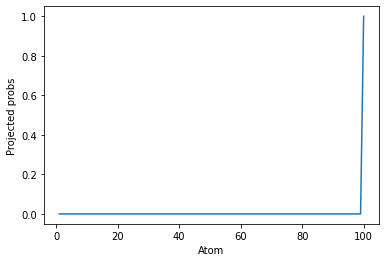

Episode 343\ Score: 79.17NaN Reward Found! Setting to -5.0...

NaN found in states. Skipping this episode.
Episode 348\ Score: 108.25

scripts\d4pg_agent.py:187: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue
scripts\d4pg_agent.py:180: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue



NaN found in actions. Skipping this episode.
Episode 349\ Score: 58.21
NaN found in states. Skipping this episode.
Episode 350: 	Actor Loss: nan 	Critic Loss: nan 
		Average Score: 65.50

SCORES (this eps):  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 



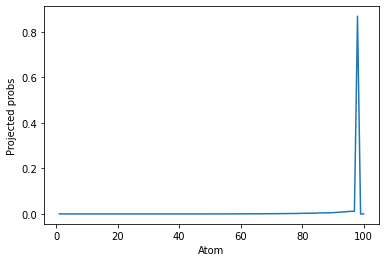


NaN found in actions. Skipping this episode.
Episode 351\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 352\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 353\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 354\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 355\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 356\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 357\ Score: 0.00
NaN found in states. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

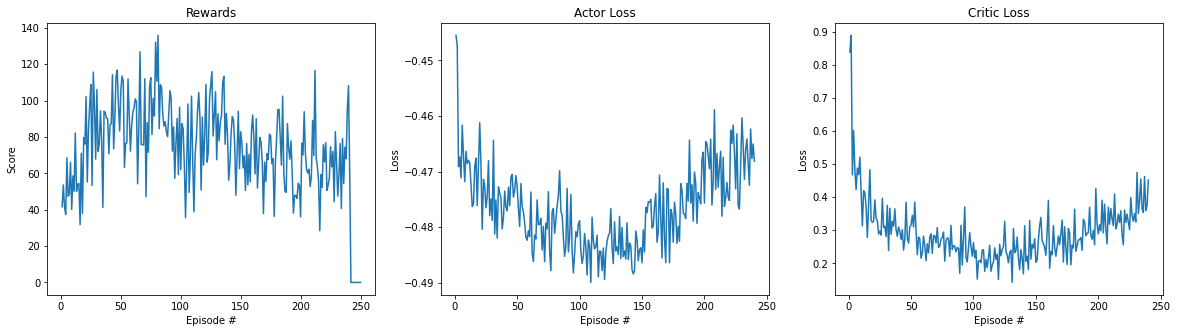

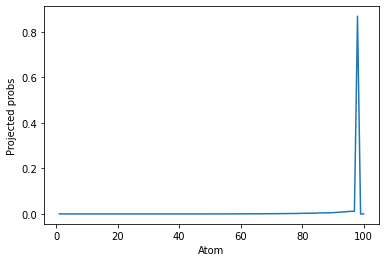

[41.627698211581446,
 53.62116257452484,
 41.430190108076204,
 37.37529083574191,
 68.56759456399595,
 47.47117829254906,
 48.633387713867705,
 66.12177085573785,
 40.16328472077536,
 58.616948367174096,
 50.15206670536039,
 82.18142417583537,
 50.09020728319107,
 54.0167691304329,
 54.46105587334993,
 31.769725351710804,
 71.09874848291899,
 37.98156850389205,
 79.66187109608047,
 76.08139664877672,
 102.22914924713162,
 55.26288321338749,
 84.08501723244262,
 97.6042485795333,
 108.76235551227971,
 53.33366903274631,
 115.67381598784898,
 97.26300429777864,
 67.87171628978103,
 106.1240509555937,
 72.11927513303817,
 76.09844029493009,
 94.38693986216094,
 78.20462109226112,
 41.30762680041759,
 94.1840672174197,
 93.45008823395862,
 90.31032623672702,
 90.14382041924789,
 70.7587057100997,
 86.74237176709964,
 87.28425214148592,
 114.20315428842635,
 73.40699788054917,
 90.3237667476448,
 113.22649310721317,
 116.83889928269006,
 97.57783896850499,
 83.2791387201675,
 105.6564749633

In [39]:
# NOTE: Can try to apply gradual decay after this...

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.5'
params.num_atoms = 100
params.vmin = -0.5
params.vmax = 0.5

params.restart_training = False
params.eps_to_resume_from = 101
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep100.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep100.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.5
VMAX:  0.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 190: 	Actor Loss: -0.49 	Critic Loss: 0.10 
		Average Score: 35.50

SCORES (this eps):  [ 11.82836784  19.46165899  67.16538357   3.97810496 111.63337406
   1.5440591   15.78798954 185.11961957   8.22688929  90.64363476
  50.17413858   5.61336711] 



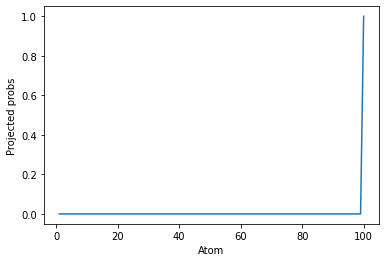

Episode 200: 	Actor Loss: -0.49 	Critic Loss: 0.11 
		Average Score: 67.43

SCORES (this eps):  [ 26.39244662  21.02323865 103.91716517 127.71069172  78.69250985
  45.3522153  115.34911971  20.97775023 111.69678276  15.63124856
  93.11186614 116.67775373] 



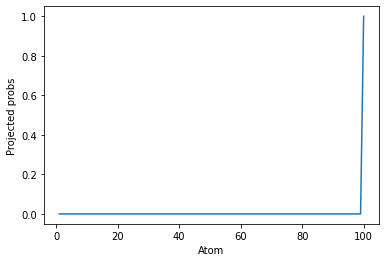

Episode 210: 	Actor Loss: -0.48 	Critic Loss: 0.25 
		Average Score: 36.58

SCORES (this eps):  [12.54103765  3.65511068  5.88712378  5.37260985 19.87742734  1.98402725
  5.15314113 18.03019536  3.01564004  8.1490626  23.45681134  5.12510192] 



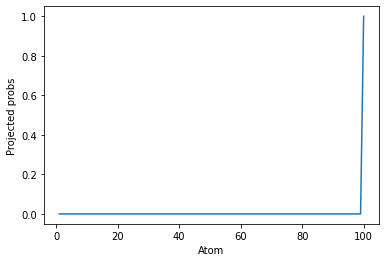

Episode 211\ Score: 3.47

In [ ]:
# NOTE: Tried to reduce OU-Noise to action space by half to reduce randomness (i.e. reduce exploration, exploit more)

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0.25        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.5'
params.num_atoms = 100
params.vmin = -0.5
params.vmax = 0.5

# REDUCE NOISE NOW
params.action_noise_theta = 0.075
params.action_noise_sigma = 0.1

params.restart_training = False
params.eps_to_resume_from = 181
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep180.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep180.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

# Other experimentations

In [9]:
#######################
# SEEMS TO WORK WELL SO FAR... (+130 rewards)
#######################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 2048

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -11.96 	Critic Loss: 1.98 
		Average Score: 21.48

Episode 127\ Score: 131.2479

ERROR:root:Exception calling application: pickle data was truncated
Traceback (most recent call last):
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\multiprocessing\connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
_pickle.UnpicklingError: pickle data was truncated
ERROR:root:Exception calling application: 
Traceback (most recent call last):
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn

KeyError: 'CrawlerBrain'


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  400
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -16.26 	Critic Loss: 1.55 
		Average Score: 20.83

Episode 200: 	Actor Loss: -10.93 	Critic Loss: 1.24 
		Average Score: 81.62

Episode 300: 	Actor Loss: -16.14 	Critic Loss: 1.34 
		Average Score: 200.95



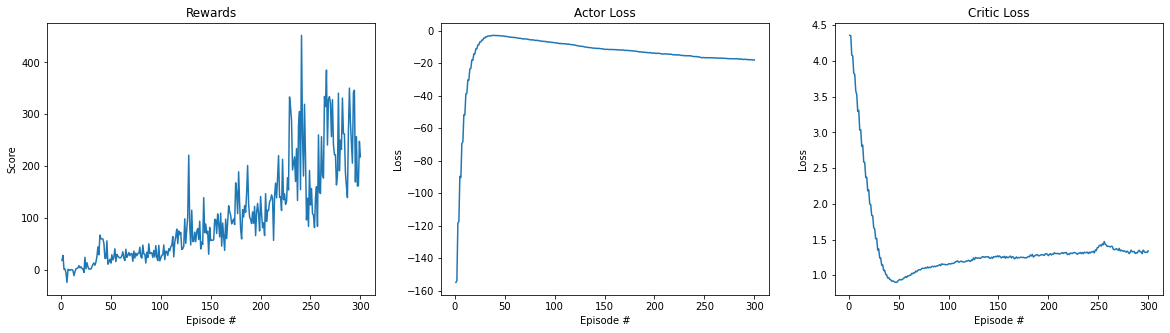


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  100
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -7.40 	Critic Loss: 2.30 
		Average Score: 9.43

Episode 174\ Score: 33.43.67NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Rewar

ValueError: The histogram is empty, please file a bug report.

In [16]:
##################
# Achieved rewards @ eps~=400 in 300 episodes
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=300
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 400
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# NaN rewards @ eps~=100
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=300
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 100
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

# Resuming training from previous weights...

In [30]:
##################
# Achieved rewards @ eps~=400 in 300 episodes
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=3000
params.max_t = 1000
params.print_every = 1
params.save_every = 10
params.log_weights_every = 1
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-6                  
params.lr_critic = 5e-5 
params.vmin = -1
params.vmax = 400
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

params.restart_training = False
params.eps_to_resume_from = 231
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic'
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep230.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep230.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  5e-06
LR_CRITIC:  5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  400
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

tensor([0.0000e+00, 1.0577e-01, 2.6953e-01, 3.2547e-01, 2.4419e-01, 4.8858e-02,
        3.6379e-03, 3.0371e-04, 1.9448e-04, 1.6048e-04, 1.3094e-04, 1.3376e-04,
        1.1185e-04, 9.2470e-05, 9.1216e-05, 9.1566e-05, 7.0925e-05, 6.5131e-05,
        7.7602e-05, 5.8450e-05, 5.2630e-05, 5.5416e-05, 5.1025e-05, 4.6327e-05,
        4.6095e-05, 4.2831e-05, 3.6946e-05, 3.4031e-05, 3.7154e-05, 3.8842e-05,
        3.0156e-05, 2.5225e-05, 2.8697e-05, 2.3088e-05, 2.2825e-05, 2.6748e-05,
        2.4898e-05, 2.2210e-05, 2.0443e-05, 1.7347e-05, 

tensor([7.1637e-04, 2.5461e-02, 1.9041e-01, 5.1483e-01, 2.5374e-01, 1.1555e-02,
        4.1493e-04, 1.0443e-04, 1.9850e-04, 1.8113e-04, 1.8350e-04, 1.4967e-04,
        1.3577e-04, 1.1169e-04, 1.2027e-04, 1.0332e-04, 8.6456e-05, 8.6825e-05,
        8.9511e-05, 7.2187e-05, 6.4506e-05, 7.3937e-05, 5.9643e-05, 5.7955e-05,
        6.0638e-05, 4.9688e-05, 4.3485e-05, 5.0960e-05, 4.7496e-05, 4.2265e-05,
        4.1389e-05, 3.6672e-05, 3.0006e-05, 3.2761e-05, 3.2342e-05, 3.2644e-05,
        3.2590e-05, 2.8898e-05, 2.7909e-05, 2.0809e-05, 1.8759e-05, 2.2031e-05,
        2.0229e-05, 1.8854e-05, 2.0374e-05, 2.1811e-05, 1.8896e-05, 1.8269e-05,
        1.7617e-05, 1.0372e-05, 1.0005e-05, 1.1760e-05, 1.0890e-05, 1.0015e-05,
        1.0943e-05, 1.1687e-05, 1.0050e-05, 1.0926e-05, 1.0839e-05, 1.1765e-05,
        9.8271e-06, 6.9852e-06, 5.3591e-06, 4.0631e-06, 4.0631e-06, 4.7403e-06,
        4.4017e-06, 4.0631e-06, 4.4016e-06, 4.7403e-06, 4.0631e-06, 4.0631e-06,
        5.0788e-06, 4.0631e-06, 4.4016e-



==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([1.9171e-01, 6.7864e-01, 4.1872e-01, 1.1115e+00, 9.3391e-01, 8.7517e-01,
        8.0484e-01, 8.3174e-01, 1.1408e+00, 8.0735e-01, 3.0553e-41, 7.5992e-01,
        7.1437e-01, 5.4217e-01, 4.3828e-01, 4.0554e-01, 5.0402e-01, 3.0553e-41,
        7.7494e-01, 7.7726e-01, 6.9113e-01, 4.9815e-01, 4.4453e-01, 5.2207e-01,
        5.2519e-01, 6.6595e-01, 5.7145e-01, 5.2822e-01, 4.8950e-01, 3.0553e-41,
        4.7936e-01, 5.6497e-01, 6.9114e-01, 6.8524e-01, 5.5990e-01, 5.1654e-01,
        5.2630e-01, 5.6571e-01, 7.3785e-01, 6.9673e-01, 6.7165e-01, 6.3027e-01,
        3.0553e-41, 3.0553e-41, 4.9219e-01, 3.0553e-41, 7.5465e-01, 7.6710e-01,
        6.1007e-01, 4.9750e-01, 4.4752e-01, 5.4672e-01, 5.4929e-01, 5.9262e-01,
        4.9883e-01, 4.8778e-01, 5.4161e-01, 3.0553e-41, 4.7556e-01, 5.6392e-01,
        7.0884e-01, 6.6669e-01, 4.7856e-01, 5.0000e-01, 4.7839e-01, 5.1477e-01,
        7.2102e-01, 

KeyboardInterrupt: 

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [15]:
# load the weights from file
params = Params()
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
agent.actor_local.load_state_dict(torch.load('weights/saved/checkpoint_actor_ep224.pth'))
agent.critic_local.load_state_dict(torch.load('weights/saved/checkpoint_critic_ep224.pth'))


env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                # get the current state
score = 0                                              # initialize the score
while True:
    # Perform actions from each agent's policy network (clipped actions [0, -1])
    actions = [ agent.act(state, add_noise=False) for state in states ]  
    actions = np.stack(actions)      
    env_info = env.step(actions)[brain_name]  # send the action to the environment 
    next_states = env_info.vector_observations       # get the next state
    rewards = env_info.rewards                       # get the reward
    dones = env_info.local_done                      # see if episode has finished
    score += max(rewards)                                    # update the score
    states = next_states                                 # roll over the state to next time step
    if any(dones):                                           # exit loop if episode finished
        break
    
print("Score: {}".format(score))


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  -0.01
VMAX:  20
NUM_ATOMS:  100

Score: 16.966790332458913


When finished, you can close the environment.

In [ ]:
# env.close()